In [ ]:
import gc
import numpy as np
import pandas as pd
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy.stats import norm, ttest_ind
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import calinski_harabasz_score

In [ ]:
# Load data
# 数据准备
path1 = "D:/317research/317研究组/4 居住自选择/data/final_data/all_data/filled_data.csv"
data = pd.read_csv(path1)
data['who'] = data['who'].astype(int)

# 导入建成环境变量
path2 = "D:/317research/317研究组/4 居住自选择/data/BE_varis.csv"
be_varie = pd.read_csv(path2)
path3 = "D:/317research/317研究组/4 居住自选择/data/final_data/all_data/resident_info.csv"
resi_info = pd.read_csv(path3)

<Axes: xlabel='age', ylabel='Count'>

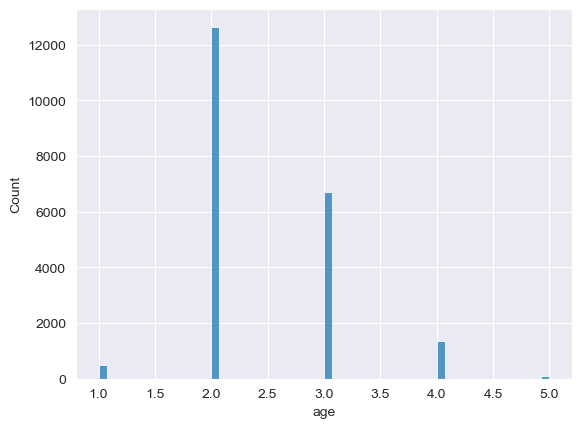

In [3]:
# 先给age重新分组
data['age'] = pd.cut(data['age'],bins=[0, 5, 7, 10, 14, float('inf')],labels=['Teenager', 'YoungAdult', 'Adult', 'MiddleElder', 'Elder'], right=False, ordered=False)
# 定义类别到数值的映射
age_mapping = {'Teenager': 1, 'YoungAdult': 2, 'Adult': 3, 'MiddleElder': 4, 'Elder': 5}
# 将类别替换为对应的数值
data['age'] = data['age'].map(age_mapping)
data['age'] = data['age'].astype(int)

sns.histplot(data[['who','age']].drop_duplicates()['age'])

In [ ]:
data['age'].mean()

In [4]:
# 建成环境特征数据
features = pd.merge(resi_info,be_varie,on='fnid',how='left')
features = features.drop(['row','column'],axis=1)
features.rename(columns={'date':'yearmonth'},inplace=True)
# 对work_dist一列的缺失值以0填充
features['work_dist'] = features['work_dist'].fillna(0)
features.head()

,who,yearmonth,fnid,group_id,move_dist,work_dist,density,landusemix,openratio_wide,intersections,...,dock,coach,eat,shop,hosp,subway,bus,edu,married,rent
0,68388056,20190101,38219,1,0.000000,5.280573,22.899753,0.611653,0.004943,14.222222,...,23.644266,0.040053,154.666667,279.111111,17.777778,0.000000,1.777778,0.059735,0.420117,1.968875
1,68229702,20191101,20076,2,8.657041,15.100863,30.440739,0.679730,0.090957,48.000000,...,12.549445,2.726802,142.222222,369.777778,65.777778,1.777778,10.666667,0.329922,0.516232,3.754838
2,68176269,20190701,23959,2,10.720544,20.660520,52.334233,0.622178,0.296840,12.444444,...,20.020197,0.604807,224.000000,368.000000,21.333333,0.000000,1.777778,0.026876,0.380712,1.766597
3,67686406,20190601,36512,2,7.318999,0.000000,49.070150,0.744327,0.068630,37.333333,...,27.033821,2.312159,528.000000,1317.333333,88.888889,0.000000,8.888889,0.029885,0.404828,1.945102
4,67656950,20190501,30376,1,0.000000,1.767251,17.133594,0.671043,0.049394,26.666667,...,23.518726,0.085487,254.222222,410.666667,35.555556,0.000000,7.111111,0.322048,0.311843,1.615556


## step1: 建成环境变化量计算

In [5]:
# 建成环境汇总
be_list = ['density', 'landusemix', 'road_density', 'intersections', 'openratio_wide', 'center', 'subway','bus','work_dist']
features = features[features['group_id']!=-1]
features_group = features.groupby(['who','group_id'])[be_list].mean().reset_index()

In [9]:
features_group.groupby('group_id').agg(['mean','std'])

who                  density            landusemix  \
                  mean           std       mean        std       mean   
group_id                                                                
1         3.962252e+07  2.284686e+07  37.780748  24.236267   0.667136   
2         3.962252e+07  2.284686e+07  35.250816  23.955336   0.669469   

                   road_density            intersections             \
               std         mean        std          mean        std   
group_id                                                              
1         0.078356    29.394870   9.917248     33.196460  24.141454   
2         0.076492    28.658407  10.210501     30.710772  22.119707   

         openratio_wide              center              subway            \
                   mean       std      mean       std      mean       std   
group_id                                                                    
1              0.086082  0.105415  6.455956  3.849976  0.508775  0.751734   
2              0.089924  0.108075  6.371693  3.916961  0.449055  0.700138   

               bus          work_dist            
              mean      std      mean       std  
group_id                                         
1         7.926448  4.03589  4.952836  4.892061  
2         7.650588  3.89236  4.959500  5.296552

In [16]:
#计算cohen'd
features_before = features_group[features_group['group_id']==1][be_list]
features_after = features_group[features_group['group_id']==2][be_list]

effect_sizes = []
for cl in be_list:
    cohen = cohen_d(features_after[cl], features_before[cl])
    # cohen_d_after = cohen_d(treat_after[cl], control_after[cl])
    effect_sizes.append([cl, np.abs(cohen)])
    # effect_sizes.append([cl, 'after', cohen_d_after, p_after])

pd.DataFrame(effect_sizes, columns=['feature', 'effect_size'])

,feature,effect_size
0,density,0.104993
1,landusemix,0.030138
2,road_density,0.073171
3,intersections,0.107361
4,openratio_wide,0.035986
5,center,0.021697
6,subway,0.082215
7,bus,0.069578
8,work_dist,0.001307


In [6]:
# 计算每个who的组数
group_num = features_group.groupby('who')['group_id'].count()
num_counts = group_num.value_counts().reset_index()
num_counts.columns = ['group_num','counts']

print(num_counts)

   group_num  counts
0          2   21289


In [7]:
be_list = ['density', 'landusemix', 'road_density', 'intersections', 'center', 'bus','subway']
# 计算groupid=1时各建成环境变量为0的数量
zero_count = features_group[features_group['group_id']==1][be_list].apply(lambda x: (x==0).sum())
print(be_list)
print(zero_count)

['density', 'landusemix', 'road_density', 'intersections', 'center', 'bus', 'subway']
density              7
landusemix           0
road_density         2
intersections       86
center             818
bus                134
subway           12109
dtype: int64


In [6]:
# 计算每个who的两组建成环境的相对变化量
# be_list = ['density', 'landusemix', 'road_density', 'intersections', 'center', 'bus','subway'] # subway的变化比较好认定
relative_changes = []
for who in features_group['who'].unique():
    df_who = features_group[features_group['who'] == who]
    group1 = df_who[df_who['group_id'] == 1]
    group2 = df_who[df_who['group_id'] == 2]
    
    # Calculate relative change
    # change = np.abs(group2[be_list].values - group1[be_list].values) / \
    #          ((group1[be_list].values + group2[be_list].values) / 2)
    change = group2[be_list].values - group1[be_list].values
    # 如果是‘subway’，那么直接计算绝对变化，否则计算相对变化
    # change = np.zeros((1, len(be_list)))
    # # Calculate changes for each feature
    # for i, feature in enumerate(be_list):
    #     if (feature != 'subway') or (feature != 'bus') :
    #         # Calculate relative change
    #         change[0, i] = (group2[feature].values - group1[feature].values) / group1[feature].values
    #     else:
    #         # Calculate absolute change for subway
    #         change[0, i] = group2[feature].values - group1[feature].values
    
    change = change.flatten()
    relative_changes.append(change)

# Create a dataframe for relative changes
relative_changes_df = pd.DataFrame(
    relative_changes,
    columns = be_list
)
relative_changes_df['who'] = features_group['who'].unique()

In [17]:
relative_changes_df.std()

density           3.157496e+01
landusemix        1.080988e-01
road_density      1.338530e+01
intersections     3.047378e+01
openratio_wide    1.460589e-01
center            5.303135e+00
subway            9.608898e-01
bus               5.432142e+00
work_dist         6.035617e+00
who               2.284686e+07
dtype: float64

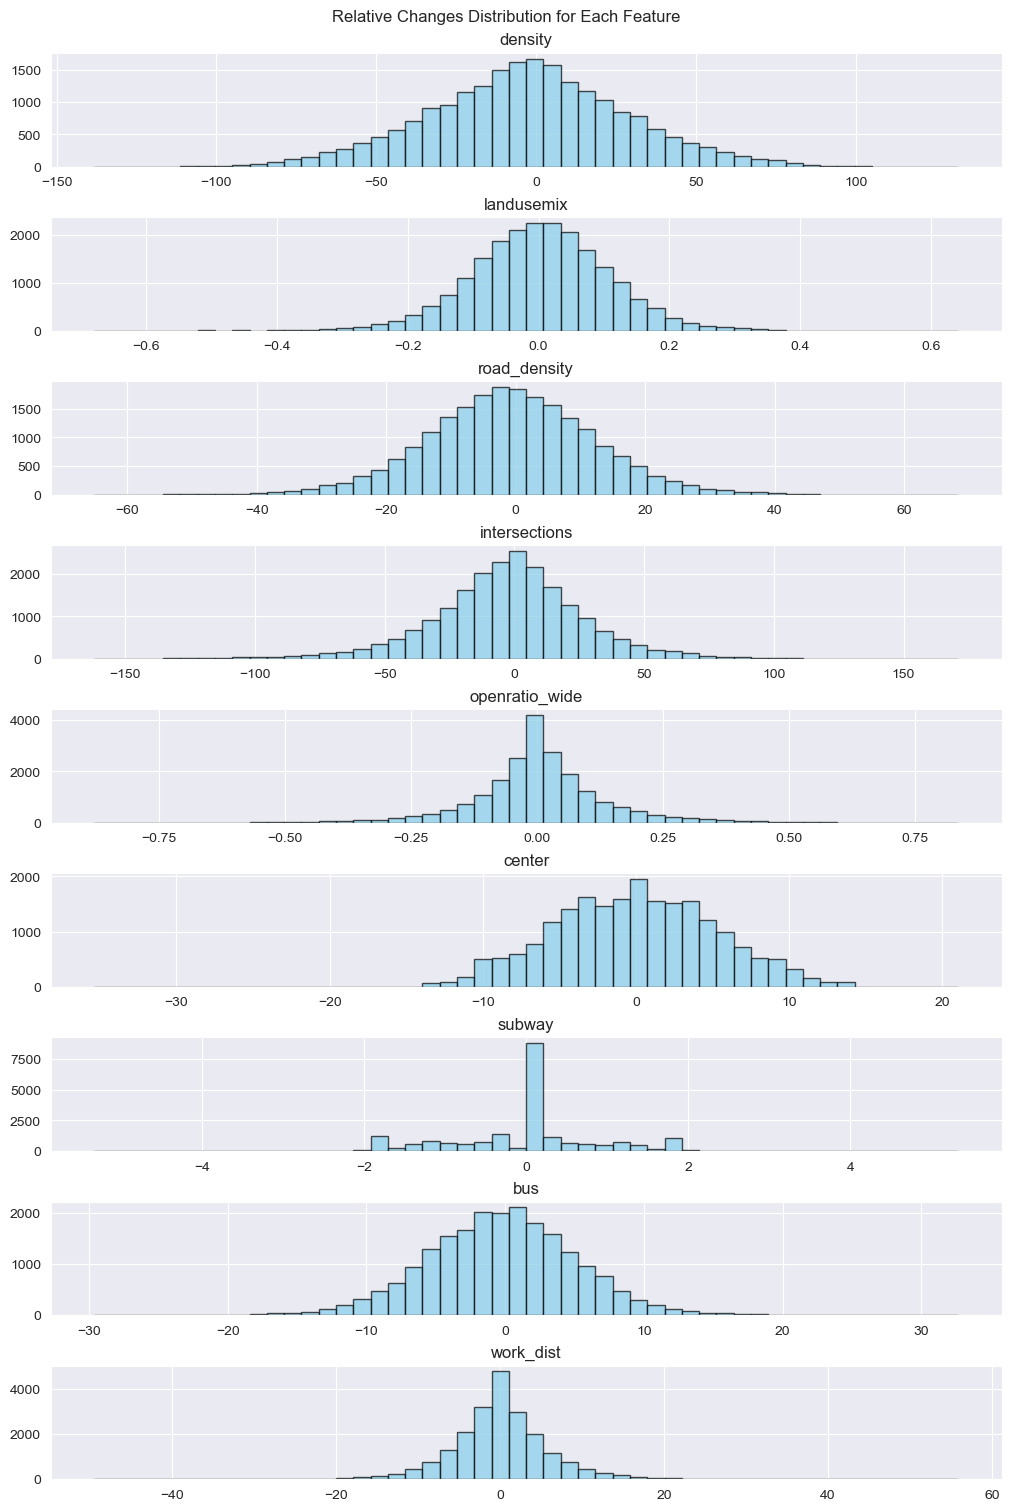

In [11]:
# Plotting
fig, axs = plt.subplots(len(be_list), figsize=(10, 15), constrained_layout=True)
fig.suptitle('Relative Changes Distribution for Each Feature')

for i, feature in enumerate(be_list):
    axs[i].hist(relative_changes_df[feature].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axs[i].set_title(feature)

plt.show()

In [8]:
# paired t-test with a known variance
def t_test_paired_known_var(differences, V, m0=0, alpha=0.5, alternative="two-sided"):
    # M = np.mean(differences)
    # n = len(differences)
    M = differences
    n = 1
    sigma = np.sqrt(V)
    S = sigma / np.sqrt(n)
    statistic = (M - m0) / S

    if alternative == "two-sided":
        p_value = 2 * norm.sf(np.abs(statistic))
    elif alternative == "less":
        p_value = norm.cdf(statistic)
    else:
        p_value = norm.sf(statistic)

    LCL = M - S * norm.ppf(1 - alpha / 2)
    UCL = M + S * norm.ppf(1 - alpha / 2)

    return {
        'mean': M, 'm0': m0, 'sigma': sigma, 'statistic': statistic,
        'p_value': p_value, 'LCL': LCL, 'UCL': UCL, 'alternative': alternative
    }

In [11]:
# 以density为例，先计算方差
for feature in be_list:
    var = relative_changes_df[feature].var()
    # 对每个who的两组建成环境的相对变化量进行t检验
    t_test_results = []
    for change in relative_changes_df[feature].values:
        t_test_results.append(t_test_paired_known_var(change, var)['p_value'])
    relative_changes_df[f'{feature}_change_p'] = t_test_results

<Axes: >

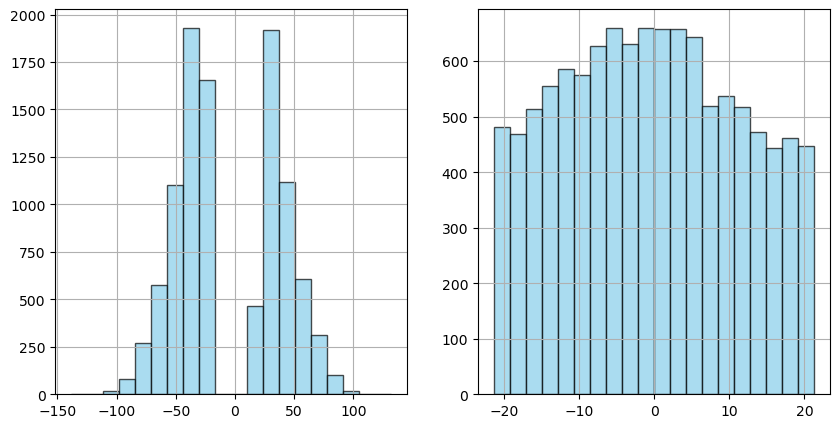

In [61]:
# 将p_value分为两组，小于0.05和大于0.05，绘制直方图
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
relative_changes_df[relative_changes_df['density_change_p']<0.5]['density'].hist(ax=axs[0], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
relative_changes_df[relative_changes_df['density_change_p']>0.5]['density'].hist(ax=axs[1], bins=20, alpha=0.7, color='skyblue', edgecolor='black')

## step2: 处置-对照组生成

In [7]:
def generate_visual_data(data, time_before, time_after):
    # 筛选出每个sample_id move_time前time_before和后time_after的数据
    #visual_data = pd.DataFrame(columns=['who','sum_dist','metro_dist_ratio','walk_dist','complexity','T'])
    visual_data = data[['who','sum_dist','metro_dist_ratio','walk_dist','T','move_time']]
    visual_data = visual_data[abs(visual_data['T'] - visual_data['move_time']) <= 120].reset_index(drop=True)
    visual_data['T'] = visual_data['T'] - visual_data['move_time'] + 120
    # visual_data = visual_data.groupby('T')[['sum_dist','metro_dist_ratio','walk_dist']].mean().reset_index()
    return visual_data

### subway

In [7]:
# 直接使用相对变化指标（是否有文献指出过多大的变化才是显著的？）
# 以subway为例，因为它可以很好地区分为处置和未处置两组
who_control = relative_changes_df[relative_changes_df['subway']==0]['who'].values
who_treatment_plus = relative_changes_df[relative_changes_df['subway']>0]['who'].values
who_treatment_minus = relative_changes_df[relative_changes_df['subway']<0]['who'].values

# 在data中添加处置组和对照组的标签
data['treat'] = data['who'].apply(lambda x: -1 if x in who_treatment_minus else (1 if x in who_treatment_plus else 0))
# data['treat'] = data['who'].apply(lambda x: 0 if x in who_treatment_plus else 0)

In [13]:
data.head()

,date,who,sum_dist,metro_dist,metro_dist_ratio,walk_dist,walk_dist_ratio,chain_complexity,gender,age,T,move_time,P,move,holiday,weekday,treat
0,20190101,6717,21540.0,0.0,0.0,0.0,0.000000,2.0,0.0,8.0,1,151,0,0,1,1,1
1,20190102,6717,32521.0,0.0,0.0,0.0,0.000000,4.0,0.0,8.0,2,151,0,0,0,2,1
2,20190103,6717,48364.0,0.0,0.0,0.0,0.000000,6.0,0.0,8.0,3,151,0,0,0,3,1
3,20190104,6717,20322.0,0.0,0.0,2263.0,0.111357,2.0,0.0,8.0,4,151,0,0,0,4,1
4,20190105,6717,39216.0,0.0,0.0,0.0,0.000000,2.0,0.0,8.0,5,151,0,0,1,5,1


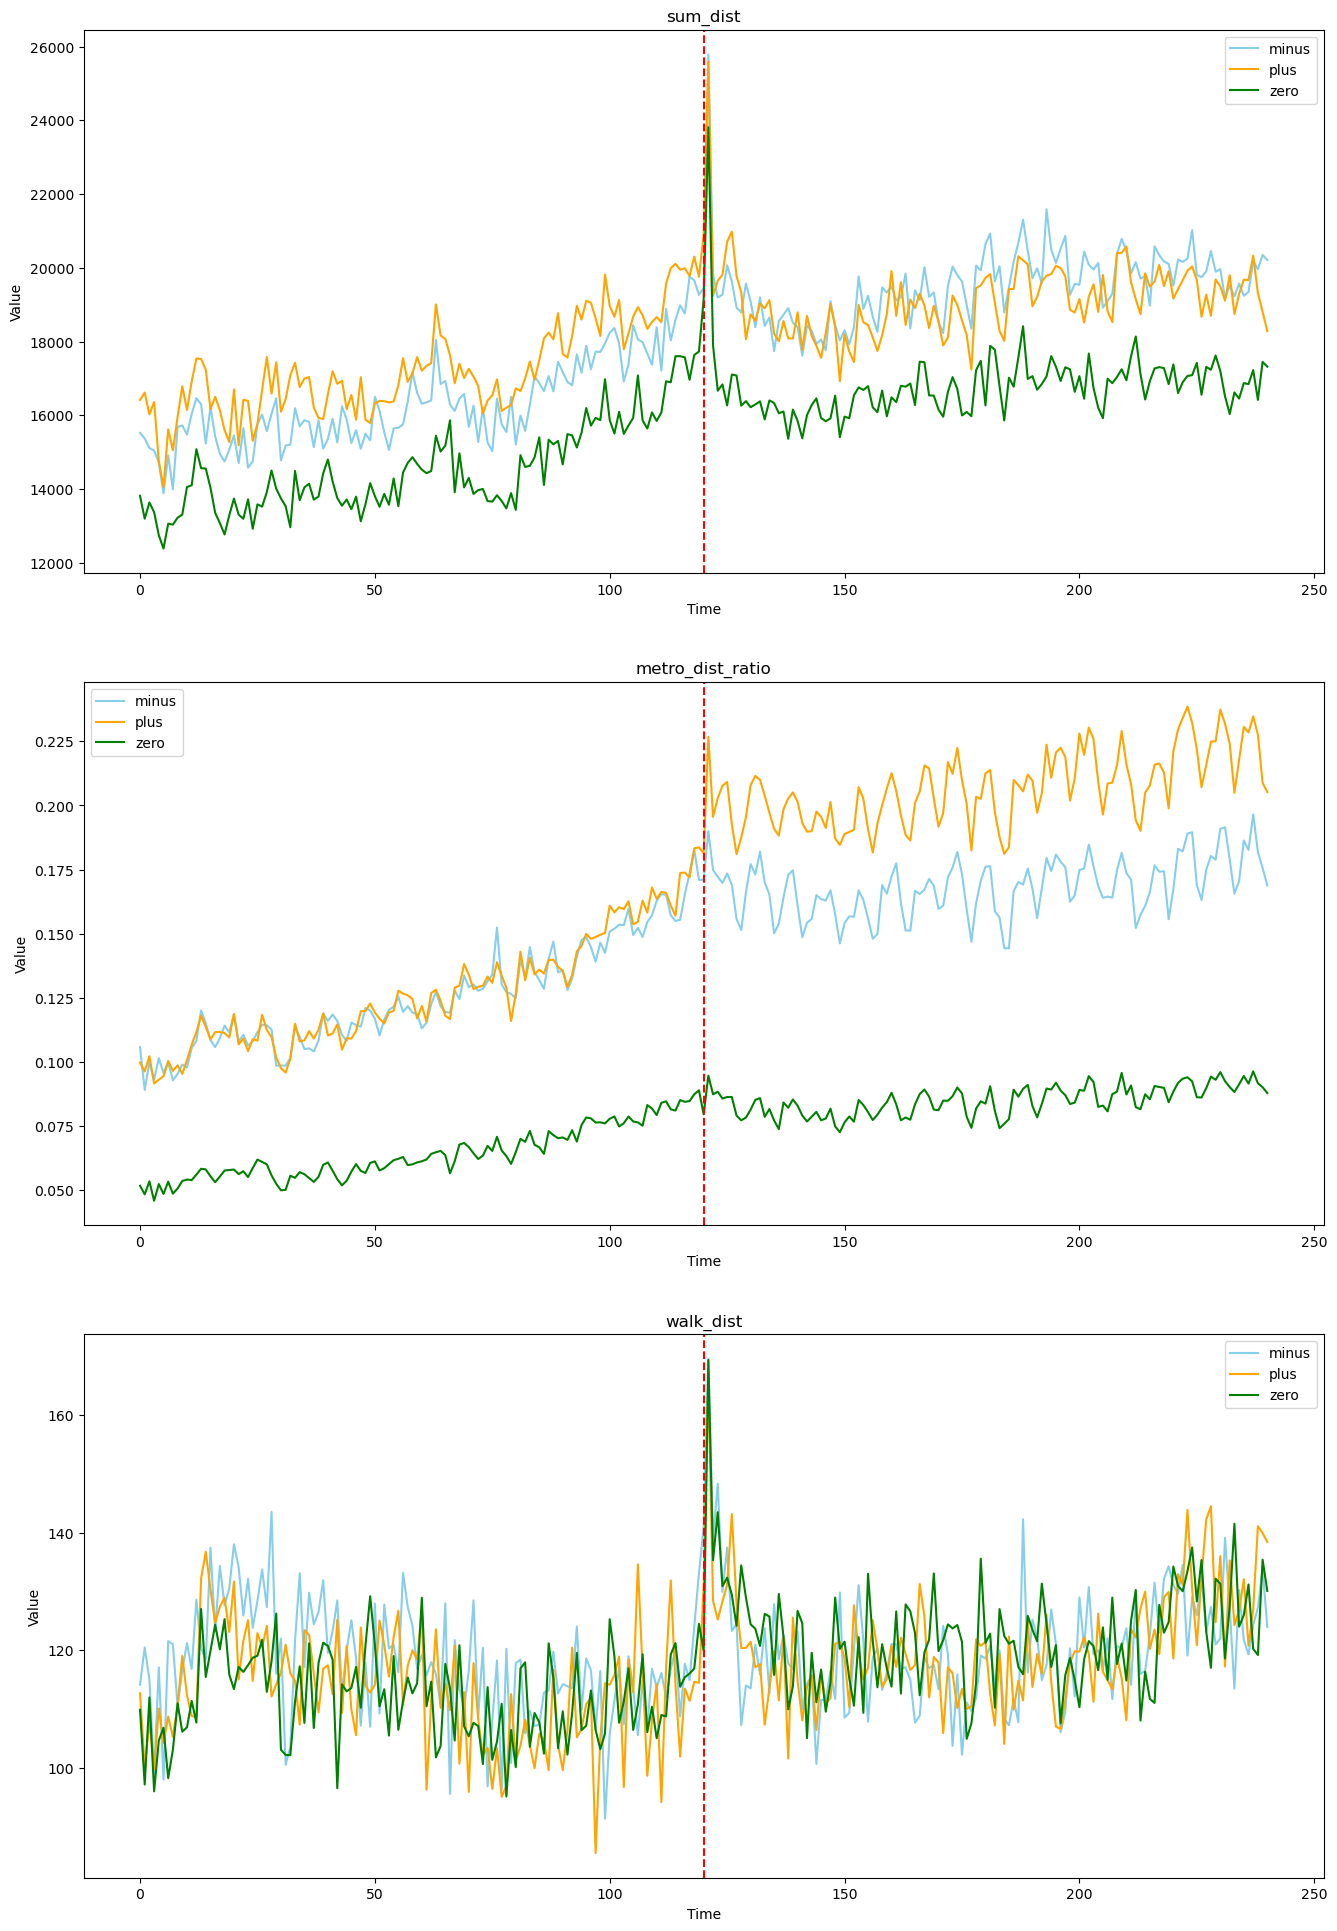

In [40]:
# 用I对齐数据，根据时间绘图
# move_time的最小值和最大值？
early_move = min(data['move_time'])
late_move = max(data['move_time'])
time_before = early_move
time_after = 365 - late_move
visual_data_minus = generate_visual_data(data[data['treat']==-1], time_before, time_after)
visual_data_plus = generate_visual_data(data[data['treat']==1], time_before, time_after)
visual_data_zero = generate_visual_data(data[data['treat']==0], time_before, time_after)

fig, ax = plt.subplots(3,1,figsize=(16,24))
for i, feature in enumerate(['sum_dist','metro_dist_ratio','walk_dist']):
    ax[i].plot(visual_data_minus['T'],visual_data_minus[feature],color='skyblue', label='minus')
    ax[i].plot(visual_data_plus['T'],visual_data_plus[feature],color='orange', label='plus')
    ax[i].plot(visual_data_zero['T'],visual_data_zero[feature],color='green', label='zero')
    ax[i].set_title(feature)
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Value')
    ax[i].axvline(x=120,ls='--',c='r')
    ax[i].legend()

In [8]:
# 用I对齐数据，根据时间绘图
# move_time的最小值和最大值？
early_move = min(data['move_time'])
late_move = max(data['move_time'])
time_before = early_move
time_after = 365 - late_move
visual_data = generate_visual_data(data, time_before, time_after)
daily_stats = visual_data.groupby('T')[['walk_dist']].agg(['mean','std']).reset_index()
# 将多级列名称修改为单级列名称
daily_stats.columns = ['T', 'mean', 'std']

In [10]:
daily_stats['I'] = daily_stats['T'].apply(lambda x: 0 if x<120 else 1)
daily_stats['P'] = daily_stats['T'].apply(lambda x: 0 if x<120 else x-120)
daily_stats['fit_Y'] = 151.411 + 0.204*daily_stats['T'] + 8.693*daily_stats['I'] - 0.334*daily_stats['P'] + 0.001*daily_stats['P']**2

In [28]:
0.334/0.002

167.0

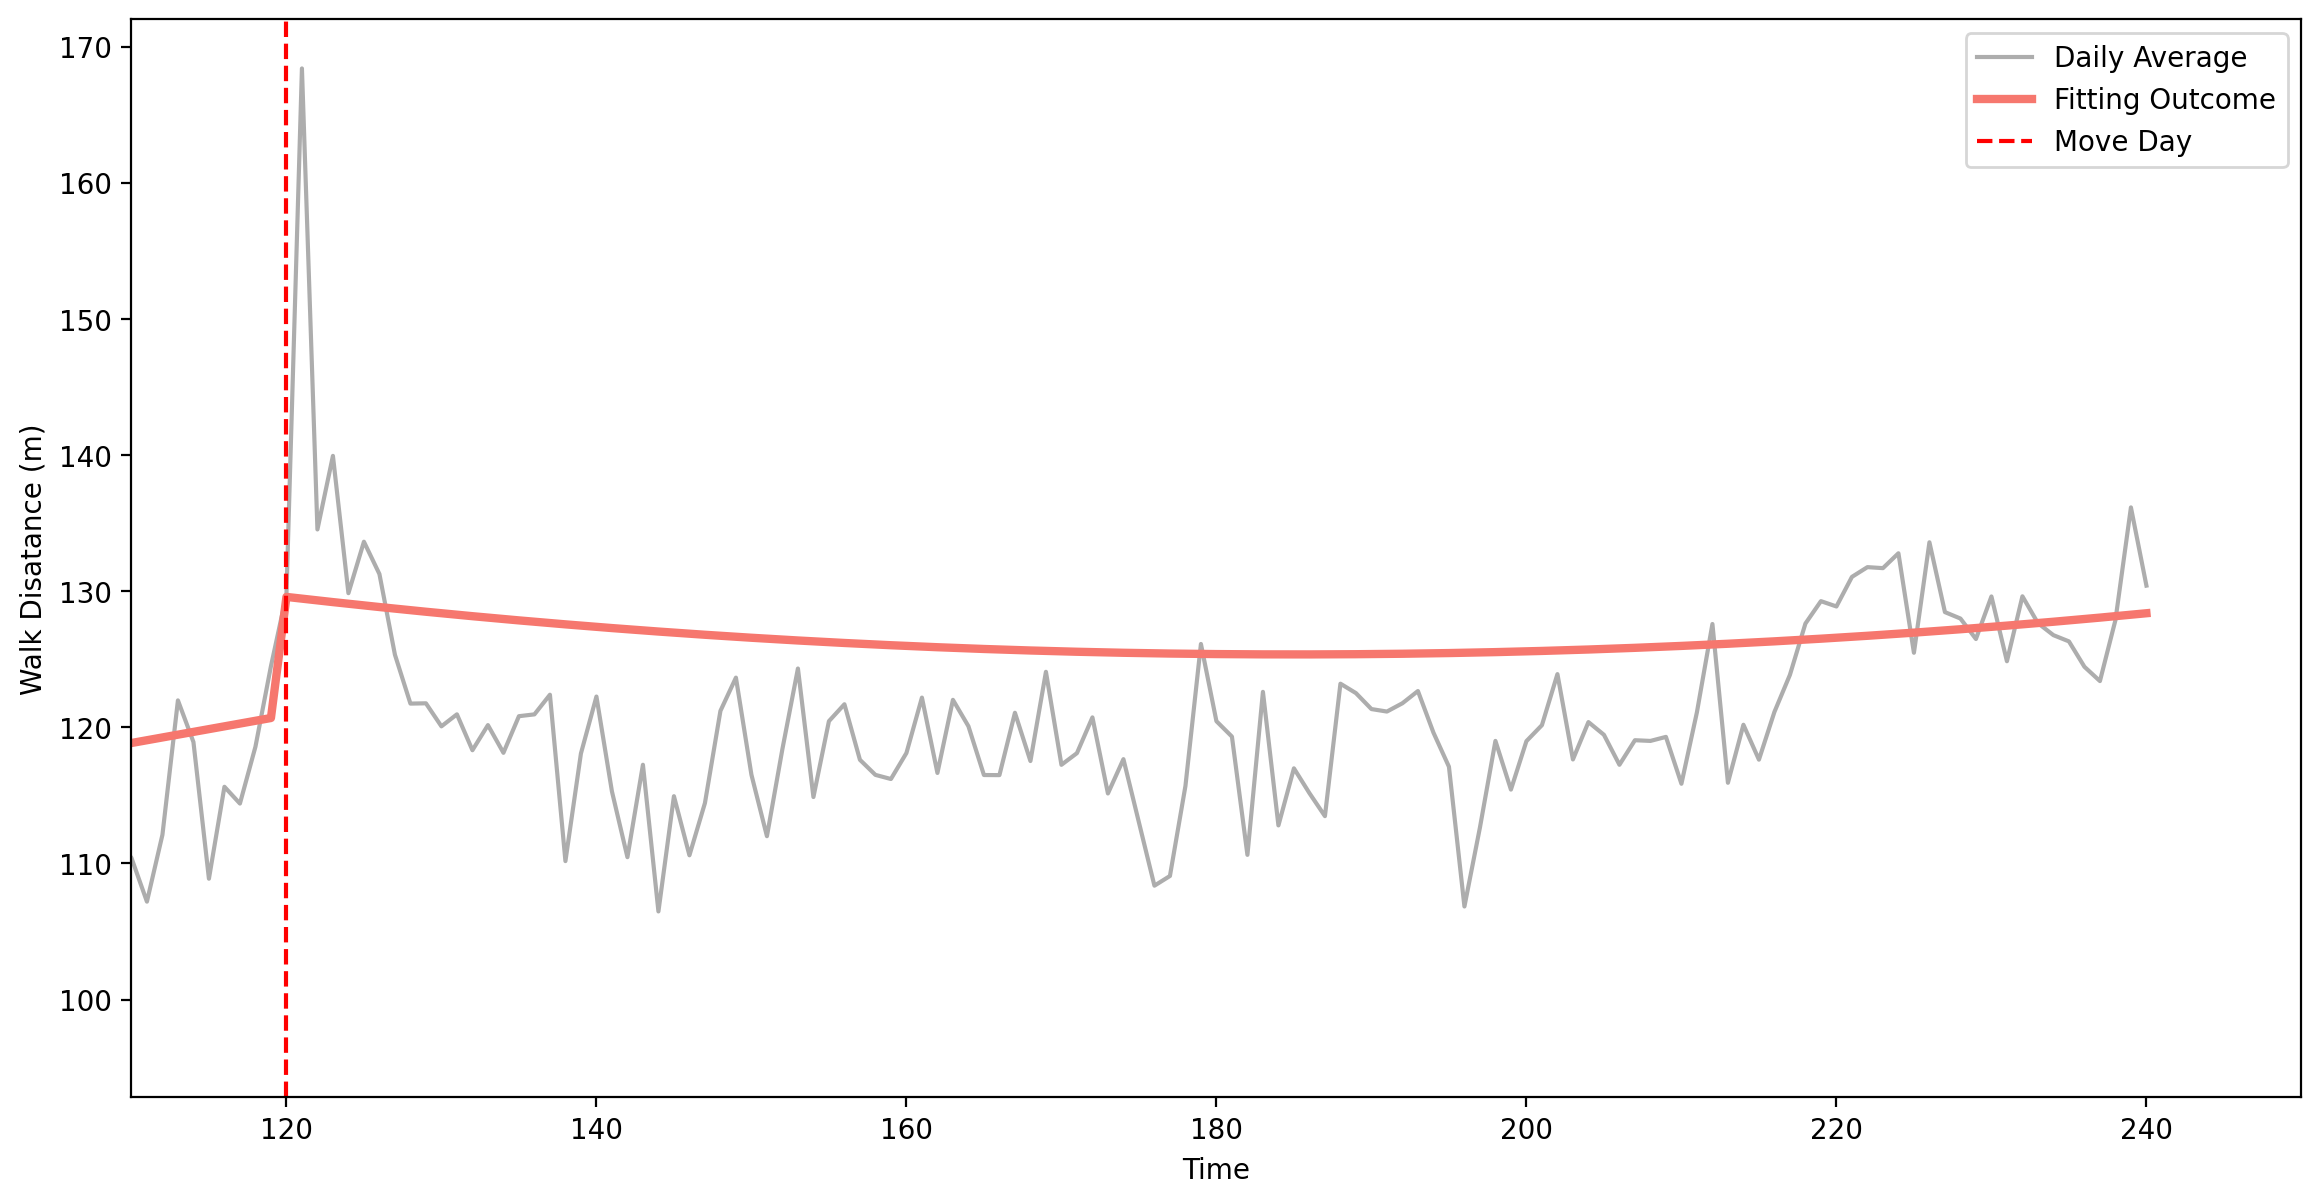

In [29]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(14,7),dpi=200)
ax.plot(daily_stats['T'],daily_stats['mean'],lw=1.5, alpha=0.8,color='#999999', label='Daily Average')
ax.plot(daily_stats['T'],daily_stats['fit_Y']-55,lw=3, color='#F6776E', label='Fitting Outcome')
ax.axvline(x=120,ls='--',c='r',label='Move Day')
ax.set_xlabel('Time')
ax.set_ylabel('Walk Disatance (m)')
ax.set_xlim([110,250])
ax.legend()

In [87]:
# data_show = visual_data[visual_data['walk_dist']<3000]
unique_users = visual_data['who'].unique()
selected_users = np.random.choice(unique_users, 8000, replace=False)
data_show = visual_data[visual_data['who'].isin(selected_users)]

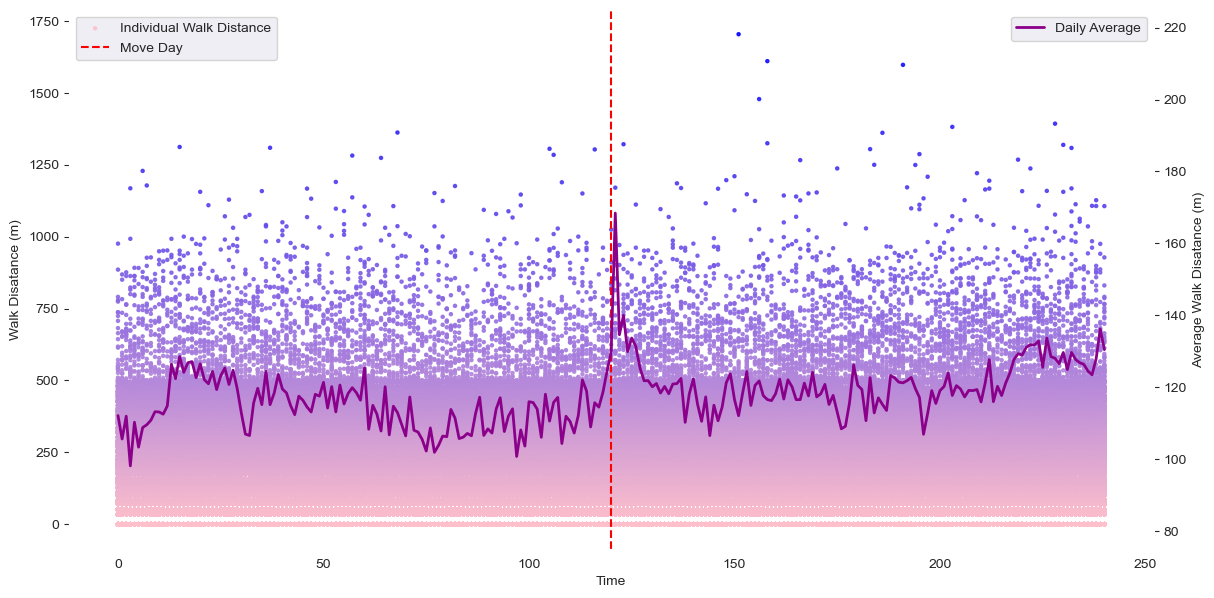

In [108]:
import matplotlib.colors as mcolors
feature='walk_dist'
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(14,7))

# 加入一些散点
cmap = mcolors.LinearSegmentedColormap.from_list("custom_pink_blue", ["pink", "blue"])
color_scatter = ax.scatter(visual_data['T'],visual_data[feature]/10,s=5, c=visual_data[feature], alpha=0.85,
                     cmap=cmap, norm=mcolors.Normalize(vmin=visual_data[feature].min(), vmax=visual_data[feature].max()), label='Individual Walk Distance')
# ax.set_title(feature)
ax.set_xlabel('Time')
ax.set_ylabel('Walk Disatance (m)')
ax.axvline(x=120,ls='--',c='r',label='Move Day')
# 添加颜色条
# cbar = fig.colorbar(color_scatter, ax=ax)
# cbar.set_label('Walk Disatance (km)')

ax_twin = ax.twinx()
ax_twin.plot(daily_stats['T'],daily_stats['mean'],color='darkmagenta',lw=2,label='Daily Average')
ax_twin.set_ylabel('Average Walk Disatance (m)')
ax_twin.set_ylim([75, 225])

ax.legend(loc='upper left')
ax.set_facecolor('white')
ax_twin.legend(loc='upper right')
ax_twin.set_facecolor('white')
ax.grid(False)
# ax.axis('on')
ax_twin.grid(False)
# ax_twin.axis('on')
plt.show()

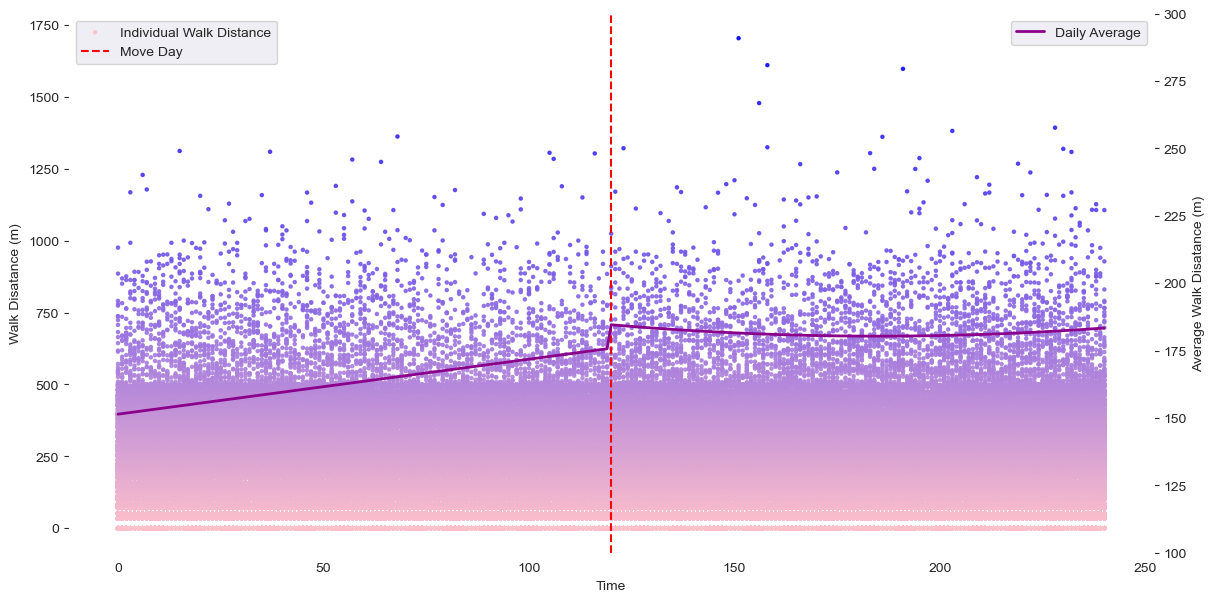

In [15]:
import matplotlib.colors as mcolors
feature='walk_dist'
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(14,7))

# 加入一些散点
cmap = mcolors.LinearSegmentedColormap.from_list("custom_pink_blue", ["pink", "blue"])
color_scatter = ax.scatter(visual_data['T'],visual_data[feature]/10,s=5, c=visual_data[feature], alpha=0.85,
                     cmap=cmap, norm=mcolors.Normalize(vmin=visual_data[feature].min(), vmax=visual_data[feature].max()), label='Individual Walk Distance')
# ax.set_title(feature)
ax.set_xlabel('Time')
ax.set_ylabel('Walk Disatance (m)')
ax.axvline(x=120,ls='--',c='r',label='Move Day')
# 添加颜色条
# cbar = fig.colorbar(color_scatter, ax=ax)
# cbar.set_label('Walk Disatance (km)')

ax_twin = ax.twinx()
ax_twin.plot(daily_stats['T'],daily_stats['fit_Y'],color='darkmagenta',lw=2,label='Daily Average')
ax_twin.set_ylabel('Average Walk Disatance (m)')
ax_twin.set_ylim([100, 300])

ax.legend(loc='upper left')
ax.set_facecolor('white')
ax_twin.legend(loc='upper right')
ax_twin.set_facecolor('white')
ax.grid(False)
# ax.axis('on')
ax_twin.grid(False)
# ax_twin.axis('on')
plt.show()

In [8]:
# 重新分配treat，准备倾向得分匹配
who_control = relative_changes_df[relative_changes_df['subway']==0]['who'].values
who_treatment = relative_changes_df[relative_changes_df['subway']!=0]['who'].values

# 在data中添加处置组和对照组的标签
data['treat'] = data['who'].apply(lambda x: 1 if x in who_treatment else 0)

### density

#### 1. 正向变化-处置组，反向变化-对照组

In [16]:
# 尝试一下正向变化为处置组，反向变化为对照组
who_control = relative_changes_df[relative_changes_df['density']<0]['who'].values
who_treatment = relative_changes_df[relative_changes_df['density']>0]['who'].values

# 在data中添加处置组和对照组的标签
data['treat'] = data['who'].apply(lambda x: 1 if x in who_treatment else 0)
# data['treat'] = data['who'].apply(lambda x: 1 if x in who_treatment_plus else 0)

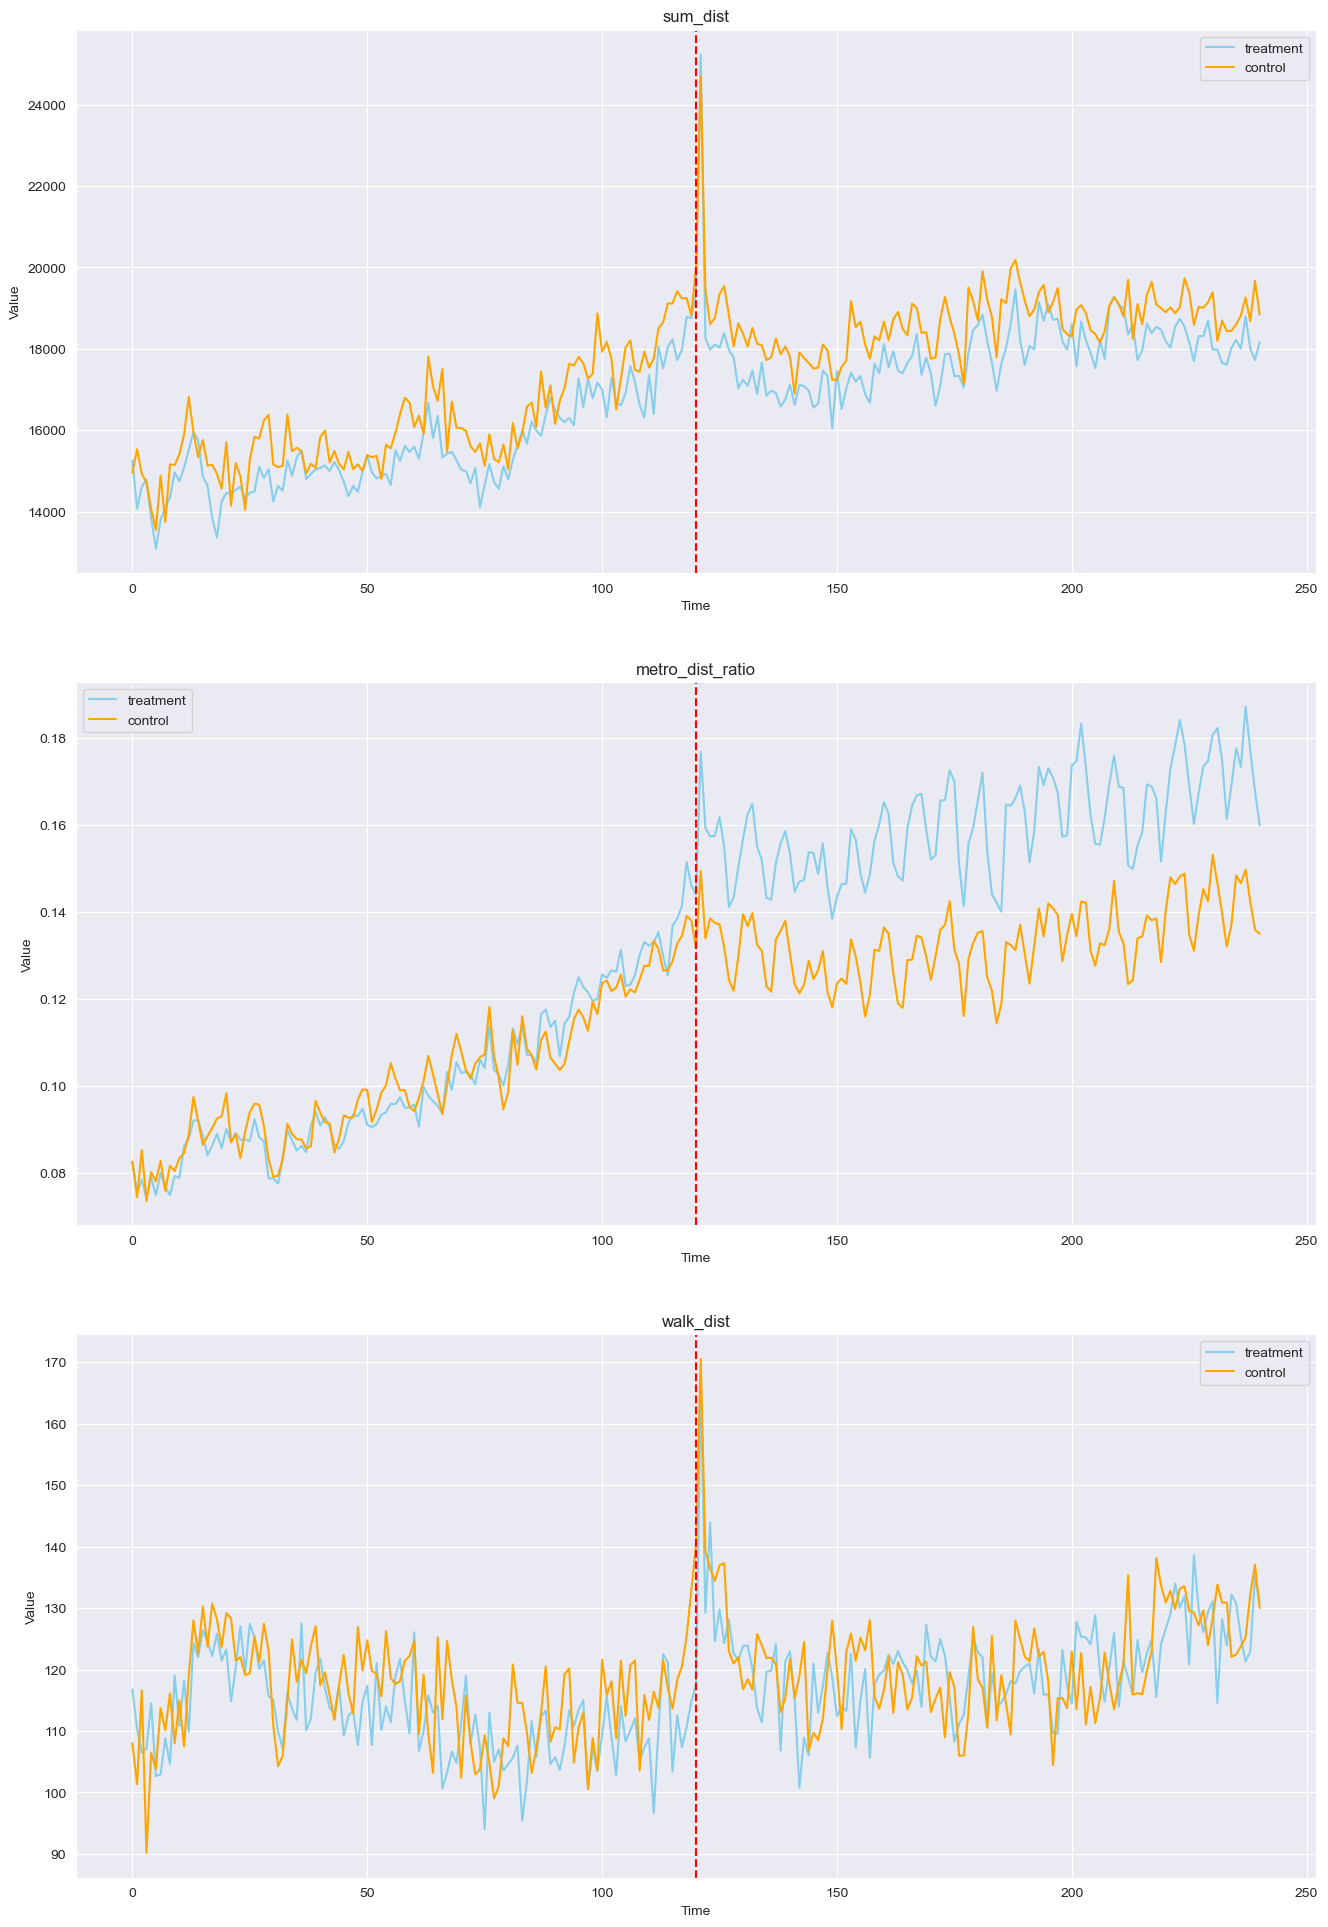

In [14]:
# 用I对齐数据，根据时间绘图
# move_time的最小值和最大值？
early_move = min(data['move_time'])
late_move = max(data['move_time'])
time_before = early_move
time_after = 365 - late_move
visual_data_treat = generate_visual_data(data[data['treat']==1], time_before, time_after)
visual_data_control = generate_visual_data(data[data['treat']==0], time_before, time_after)

fig, ax = plt.subplots(3,1,figsize=(16,24))
for i, feature in enumerate(['sum_dist','metro_dist_ratio','walk_dist']):
    ax[i].plot(visual_data_treat['T'],visual_data_treat[feature],color='skyblue', label='treatment')
    ax[i].plot(visual_data_control['T'],visual_data_control[feature],color='orange', label='control')
    ax[i].set_title(feature)
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Value')
    ax[i].axvline(x=120,ls='--',c='r')
    ax[i].legend()

#### 2. 基于聚类的treatment generation

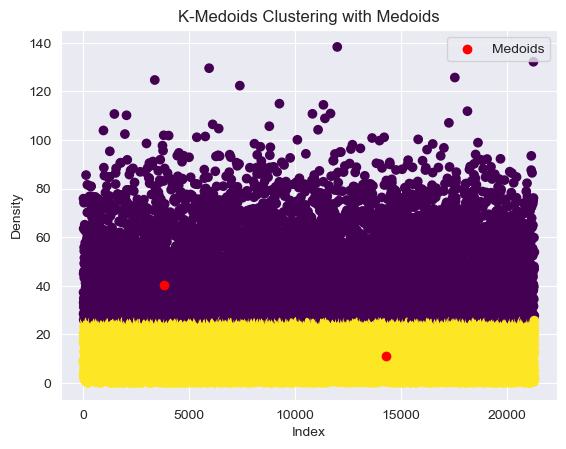

In [15]:
# 数据准备
X_data = relative_changes_df[['who','density']]
# 取绝对值
X_data['density'] = X_data['density'].apply(lambda x: abs(x))

# 直接聚类为两组看看效果，使用k-medoids
pam = KMedoids(n_clusters=2, random_state=0)
pam_cluster = pam.fit_predict(X_data[['density']])

# 可视化聚类效果
# 带有中心点的一维散点图
plt.scatter(X_data.index, X_data['density'], c=pam_cluster, cmap='viridis')
plt.scatter(pam.medoid_indices_, X_data.iloc[pam.medoid_indices_]['density'], c='red', label='Medoids')
plt.xlabel('Index')
plt.ylabel('Density')
plt.title('K-Medoids Clustering with Medoids')
plt.legend()
plt.show()

In [23]:
# 确定哪个中心值较小
medoids = X_data.iloc[pam.medoid_indices_]['density']
# 获取较小中心值的聚类标签
label_of_smaller_medoid = pam_cluster[pam.medoid_indices_[medoids.argmin()]]

# 创建新列并根据聚类中心分配标签
X_data['label'] = [0 if i == label_of_smaller_medoid else 1 for i in pam.labels_]

# 分配treat，准备倾向得分匹配
who_control = X_data[X_data['label']==0]['who'].values
who_treatment = X_data[X_data['label']==1]['who'].values

# 在data中添加处置组和对照组的标签
data['treat'] = data['who'].apply(lambda x: 1 if x in who_treatment else 0)

C:\Users\317gy\AppData\Local\Temp\ipykernel_69884\1793931289.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data['label'] = [0 if i == label_of_smaller_medoid else 1 for i in pam.labels_]


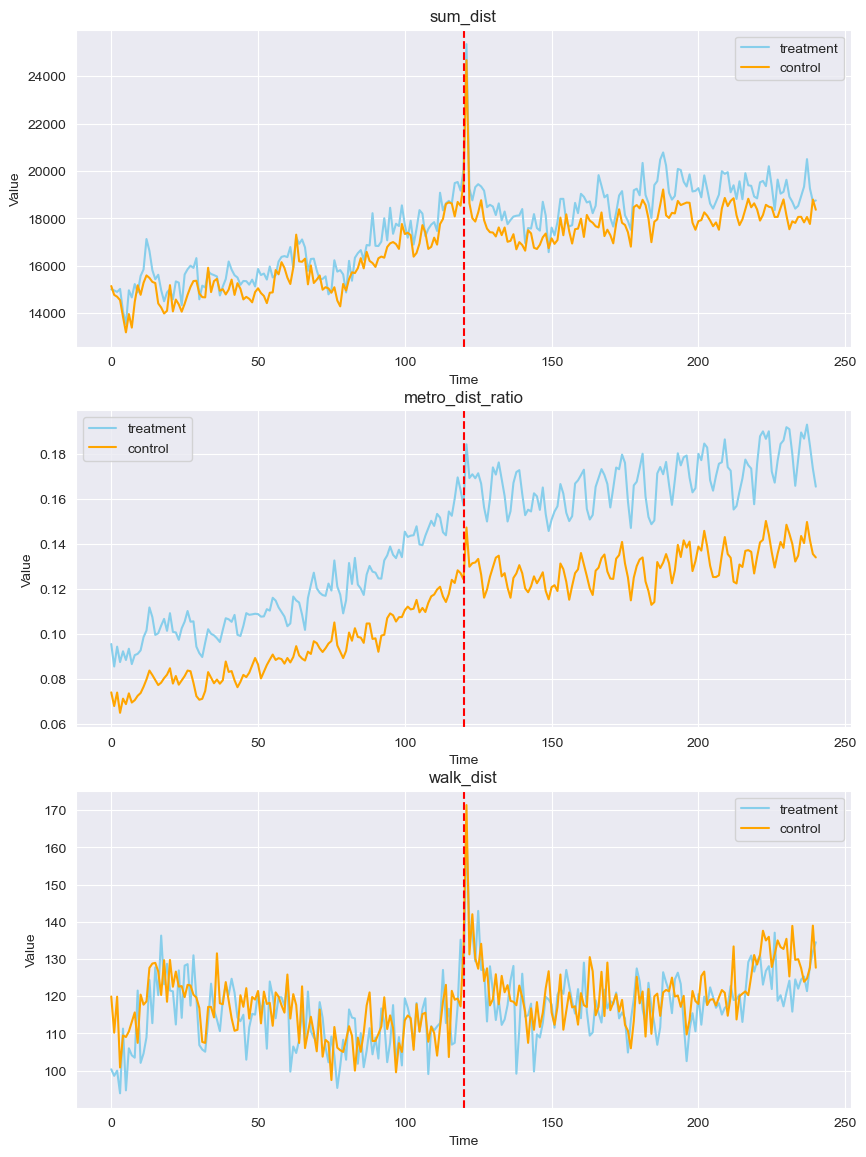

In [25]:
# 用I对齐数据，根据时间绘图
# move_time的最小值和最大值？
early_move = min(data['move_time'])
late_move = max(data['move_time'])
time_before = early_move
time_after = 365 - late_move
visual_data_treat = generate_visual_data(data[data['treat']==1], time_before, time_after)
visual_data_control = generate_visual_data(data[data['treat']==0], time_before, time_after)

fig, ax = plt.subplots(3,1,figsize=(10,14))
for i, feature in enumerate(['sum_dist','metro_dist_ratio','walk_dist']):
    ax[i].plot(visual_data_treat['T'],visual_data_treat[feature],color='skyblue', label='treatment')
    ax[i].plot(visual_data_control['T'],visual_data_control[feature],color='orange', label='control')
    ax[i].set_title(feature)
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Value')
    ax[i].axvline(x=120,ls='--',c='r')
    ax[i].legend()

### landusemix

#### 1. 正向-反向对照

In [21]:
# 尝试一下正向变化为处置组，反向变化为对照组
who_control = relative_changes_df[relative_changes_df['landusemix']<0]['who'].values
who_treatment = relative_changes_df[relative_changes_df['landusemix']>0]['who'].values

# 在data中添加处置组和对照组的标签
data['treat'] = data['who'].apply(lambda x: 1 if x in who_treatment else 0)

### road_density

In [25]:
# 正反对照
who_control = relative_changes_df[relative_changes_df['road_density']<0]['who'].values
who_treatment = relative_changes_df[relative_changes_df['road_density']>0]['who'].values

# 在data中添加处置组和对照组的标签
data['treat'] = data['who'].apply(lambda x: 1 if x in who_treatment else 0)

### Open_Ratio

In [7]:
# 正反对照
who_control = relative_changes_df[relative_changes_df['openratio_wide']<0]['who'].values
who_treatment = relative_changes_df[relative_changes_df['openratio_wide']>0]['who'].values

# 在data中添加处置组和对照组的标签
data['treat'] = data['who'].apply(lambda x: 1 if x in who_treatment else 0)

### intersections

In [29]:
# 正反对照
who_control = relative_changes_df[relative_changes_df['intersections']<0]['who'].values
who_treatment = relative_changes_df[relative_changes_df['intersections']>0]['who'].values

# 在data中添加处置组和对照组的标签
data['treat'] = data['who'].apply(lambda x: 1 if x in who_treatment else 0)

### center

In [33]:
# 正反对照
who_control = relative_changes_df[relative_changes_df['center']<0]['who'].values  # 靠近中心
who_treatment = relative_changes_df[relative_changes_df['center']>0]['who'].values  # 远离中心

# 在data中添加处置组和对照组的标签
data['treat'] = data['who'].apply(lambda x: 1 if x in who_treatment else 0)

### bus

In [37]:
# 正反对照
who_control = relative_changes_df[relative_changes_df['bus']<0]['who'].values  # 靠近中心
who_treatment = relative_changes_df[relative_changes_df['bus']>0]['who'].values  # 远离中心

# 在data中添加处置组和对照组的标签
data['treat'] = data['who'].apply(lambda x: 1 if x in who_treatment else 0)

## step3: 倾向得分匹配

In [38]:
# 协变量准备
features_list = ['density', 'landusemix', 'road_density', 'openratio_wide', 'intersections', 'center', 'work_dist', 'subway', 'bus', 'edu', 'married', 'rent']
covariates = features.groupby(['who','group_id'])[features_list].mean().reset_index()

# #############################################################################################
# 将每个 'who' 的两行数据（对应 group_id=1 和 group_id=2）合并为一行（在同时使用搬迁前后协变量构建ps模型时需要）
# 使用pivot_table 来实现这一点，并将 'group_id' 作为列
pivot = covariates.pivot_table(index='who', columns='group_id', values=features_list)
# 修改列名
# 新列名格式为 'feature' + 'group_id'
pivot.columns = ['{}{}'.format(col[0], col[1]) for col in pivot.columns]
# 重置索引以使 'who' 成为列
covariates_merge = pivot.reset_index()
covariates_merge = pd.merge(covariates_merge, data[['who','gender','age','treat']].drop_duplicates(), on='who', how='left')
# #############################################################################################

#添加个人信息，根据who连接data中的age和gender两列
covariates = pd.merge(covariates, data[['who','gender','age','treat']].drop_duplicates(), on='who', how='left')


covariates.head()  # 显示结果的前几行以进行检查

,who,group_id,density,landusemix,road_density,openratio_wide,intersections,center,work_dist,subway,bus,edu,married,rent,gender,age,treat
0,6717,1,49.195423,0.705975,30.578133,0.000000,41.955556,6.177506,13.847480,0.355556,7.466667,0.248269,0.513453,3.361441,0,3,0
1,6717,2,40.276083,0.591581,31.203556,0.129132,17.015873,8.461331,9.190034,0.000000,2.793651,0.224826,0.566411,4.749332,0,3,0
2,9226,1,84.890841,0.676412,21.968296,0.061782,33.185185,4.865238,9.232072,1.185185,9.185185,0.146842,0.312784,2.330274,0,4,0
3,9226,2,9.037319,0.713846,25.273481,0.042943,37.333333,4.161636,3.045509,1.580247,5.135802,0.218114,0.265840,4.593400,0,4,0
4,9856,1,15.218378,0.766083,48.437333,0.038691,48.000000,5.958036,6.047683,0.000000,7.111111,0.430078,0.590391,5.060880,0,3,0


In [103]:
covariates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42578 entries, 0 to 42577
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   who            42578 non-null  int64  
 1   group_id       42578 non-null  int64  
 2   density        42578 non-null  float64
 3   landusemix     42578 non-null  float64
 4   road_density   42578 non-null  float64
 5   intersections  42578 non-null  float64
 6   center         42578 non-null  float64
 7   work_dist      42578 non-null  float64
 8   bus            42578 non-null  float64
 9   edu            42578 non-null  float64
 10  married        42578 non-null  float64
 11  rent           42578 non-null  float64
 12  gender         42578 non-null  int64  
 13  age            42578 non-null  int32  
 14  treat          42578 non-null  int64  
dtypes: float64(10), int32(1), int64(4)
memory usage: 4.7 MB


In [16]:
# 检查控制组和处置组的均值
covariates.groupby('treat').mean()

,who,group_id,density,landusemix,road_density,intersections,center,work_dist,subway,bus,edu,married,rent,gender,age
treat,,,,,,,,,,,,,,,
0,3.969437e+07,1.5,36.321856,0.667269,28.870004,31.286428,6.394205,5.011873,0.463443,7.652587,0.145968,0.437271,4.031755,0.340825,2.463301
1,3.953986e+07,1.5,36.738917,0.669492,29.206866,32.721297,6.436399,4.892073,0.496718,7.944924,0.146504,0.433835,3.974563,0.348924,2.399636


In [17]:
# student's t-test for outcomes (dependent variable)
df_control = data[data['treat']==0]
df_treatment = data[data['treat']==1]

for feature in ['sum_dist','metro_dist_ratio','walk_dist']:
    print(feature)
    print(df_control[feature].mean(), df_treatment[feature].mean())
    # compare samples
    _, p = ttest_ind(df_control[feature], df_treatment[feature])
    print(f'p={p:.3f}')

    # interpret
    alpha = 0.05 # significance level
    if p>alpha:
        print('Same distributions/ same group mean (fail to reject H0)')
    else:
        print('Different distributions/ different group mean (reject H0)')

sum_dist
17281.798276786896 16571.725602004906
p=0.000
Different distributions/ different group mean (reject H0)
metro_dist_ratio
0.11924588750596093 0.13420720619921955
p=0.000
Different distributions/ different group mean (reject H0)
walk_dist
121.08586623690572 118.25876337308182
p=0.000
Different distributions/ different group mean (reject H0)


In [18]:
# 选择倾向得分计算的特征
intervention = 'density'
covariate_list = [feature for feature in features_list if feature != intervention] # 从covariate_list中删除intervention
covariate_list = covariate_list + ['gender','age']
# 只使用搬家前的协变量（基准协变量）来匹配
covariates_before = covariates[covariates['group_id']==1].reset_index(drop=True)
# 只使用搬家后的协变量来匹配
covariates_after = covariates[covariates['group_id']==2].reset_index(drop=True)

In [10]:
# 使用LogisticRegression计算倾向得分
def compute_propensity_score(X,y):
    
    # 数据缩放
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # 模型拟合
    lr = LogisticRegression()
    lr.fit(X_scaled, y)
    # 倾向得分是取1的概率（处置组的概率）
    pred_prob = lr.predict_proba(X_scaled)
    
    return pred_prob

In [11]:
# 计算倾向得分的logit形式
# 1. 直接使用倾向得分可以直观地反映处理组和对照组的概率差异。
# 2. 使用Logit of Propensity Score 可以在数值上提高匹配的精度和灵活性，特别是当倾向得分接近极限值（0或1）时。
def logit(p):
    logit_value = math.log(p / (1 - p))
    return logit_value

In [21]:
# 搬家前的倾向得分
pred_prob1 = compute_propensity_score(covariates_before[covariate_list], covariates_before['treat'])
covariates_before['ps'] = pred_prob1[:,1]
# 搬家后的倾向得分
pred_prob2 = compute_propensity_score(covariates_after[covariate_list], covariates_after['treat'])
covariates_after['ps'] = pred_prob2[:,1]

covariates_before['logit_ps'] = covariates_before['ps'].apply(logit)
covariates_after['logit_ps'] = covariates_after['ps'].apply(logit)
covariates_before.head()

,who,group_id,density,landusemix,road_density,intersections,center,work_dist,subway,bus,edu,married,rent,gender,age,treat,ps,logit_ps
0,6717,1,49.195423,0.705975,30.578133,41.955556,6.177506,13.847480,0.355556,7.466667,0.248269,0.513453,3.361441,0,3,0,0.360261,-0.574231
1,9226,1,84.890841,0.676412,21.968296,33.185185,4.865238,9.232072,1.185185,9.185185,0.146842,0.312784,2.330274,0,4,0,0.473939,-0.104339
2,9856,1,15.218378,0.766083,48.437333,48.000000,5.958036,6.047683,0.000000,7.111111,0.430078,0.590391,5.060880,0,3,1,0.303043,-0.832849
3,10560,1,80.991938,0.707634,27.444741,5.037037,11.331351,6.166892,0.000000,7.407407,0.154743,0.512861,3.941416,1,1,0,0.531582,0.126496
4,11694,1,61.468297,0.685137,31.269926,29.333333,0.123334,8.252879,0.000000,6.222222,0.119986,0.497179,2.282288,1,2,0,0.352652,-0.607401


Text(0.5, 1.0, 'after move')

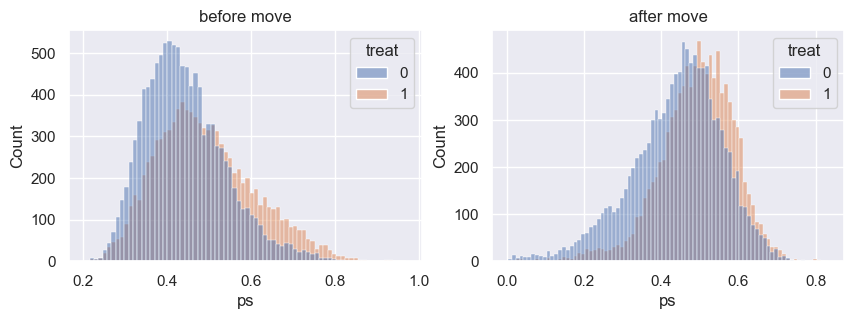

In [22]:
# 检查处置组和对照组倾向得分的重合度
# 如果重合不多，则匹配效果不好
sns.set()
fig, ax = plt.subplots(1,2,figsize=(10, 3))
sns.histplot(covariates_before, x='ps', hue='treat', ax=ax[0])
ax[0].set_title('before move')
sns.histplot(covariates_after, x='ps', hue='treat', ax=ax[1])
ax[1].set_title('after move')

In [12]:
# 使用25%标准差的caliper/radius进行匹配
# 获取每个观测值的k个最近邻
from sklearn.neighbors import NearestNeighbors
def ps_matching(data, caliper_ratio, n_neighbors, replacement=False):  #replacement=False，即同一个控制组不能被重复匹配 
    # knn parameter
    caliper = np.std(data.ps) * caliper_ratio
    print(f'caliper (radius) is: {caliper:.3f}')
    # setup knn
    knn = NearestNeighbors(n_neighbors=n_neighbors, radius=caliper)
    ps = data[['ps']]
    knn.fit(ps)
    # distances and indexs
    distances, neighbor_indexs = knn.kneighbors(ps)
    
    # 匹配：对处置组中的每个对象，找到对照组中最接近样本(with replacement)
    # 注意：之前匹配的邻居包括了处置组和对照组
    # 区分搬家前和搬家后的匹配
    match_control = []
    for current_index, row in data.iterrows():
        if row.treat == 0:  # 当前行是对照组
            data.loc[current_index, 'match'] = np.nan
        else:
            for idx in neighbor_indexs[current_index, :]:
                # neighbor在对照组
                # 匹配对象为同期的对照组（group_id）
                if data.loc[idx].treat == 0:
                    if (not replacement) and (idx not in match_control):  # 该对象没有被匹配过-without replacement做法
                        data.loc[current_index, 'match'] = idx
                        match_control.append(idx)
                        break # 实际上是1-1匹配
                    elif replacement:  # 则不需要检查是否已匹配过
                        data.loc[current_index, 'match'] = idx
                        match_control.append(idx)
                        break # 实际上是1-1匹配      
                data.loc[current_index, 'match'] = np.nan
    
    #最后返回整个data
    return data    

In [24]:
covariates_before = ps_matching(covariates_before, 0.25, 20) # data, caliper_ratio, n_neighbors
covariates_after = ps_matching(covariates_after, 0.25, 20)

caliper (radius) is: 0.027
caliper (radius) is: 0.028


In [25]:
# 搬家前时期
# 删除没有匹配的数据
treatment_matched1 = covariates_before.dropna(subset=['match'])  # 处置组
# 对照组
control_matched_idx1 = treatment_matched1.match
control_matched_idx1 = control_matched_idx1.astype(int)
control_matched1 = covariates_before.loc[control_matched_idx1,:]

In [26]:
# 搬家后时期
# 删除没有匹配的数据
treatment_matched2 = covariates_after.dropna(subset=['match'])  # 处置组
# 对照组
control_matched_idx2 = treatment_matched2.match
control_matched_idx2 = control_matched_idx2.astype(int)
control_matched2 = covariates_after.loc[control_matched_idx2,:]

In [27]:
# 检查匹配结果
print('total observations in treatment:', len(covariates_before))
print('before move: total matched observations in treatment:', len(treatment_matched1))
print('before move: total matched observations in control:', len(control_matched1))

print('after move: total matched observations in treatment:', len(treatment_matched2))
print('after move: total matched observations in control:', len(control_matched2))

total observations in treatment: 21289
before move: total matched observations in treatment: 7974
before move: total matched observations in control: 7974
after move: total matched observations in treatment: 7962
after move: total matched observations in control: 7962


In [13]:
# 看看匹配前后协变量的差异（我们的目标是让匹配后的协变量差异尽可能小）
# 定义cohen's d计算函数
def cohen_d(d1, d2):
    # 计算样本量
    n1, n2 = len(d1), len(d2)
    # 计算样本的方差
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # 计算pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # 计算means
    u1, u2 = np.mean(d1), np.mean(d2)
    # 计算cohen's d效应量
    return (u1 - u2) / s

def compute_effect_size(treat_before, treat_after, control_before, control_after, cols):
    effect_sizes = []
    for cl in cols:
        _, p_before = ttest_ind(treat_before[cl], control_before[cl])
        _, p_after = ttest_ind(treat_after[cl], control_after[cl])
        cohen_d_before = cohen_d(treat_before[cl], control_before[cl])
        cohen_d_after = cohen_d(treat_after[cl], control_after[cl])
        effect_sizes.append([cl, 'before', cohen_d_before, p_before])
        effect_sizes.append([cl, 'after', cohen_d_after, p_after])
    return pd.DataFrame(effect_sizes, columns=['feature', 'matching', 'effect_size', 'p_value'])

In [29]:
# 搬家前的匹配效果
effect_sizes_before = compute_effect_size(
    covariates_before[covariates_before['treat']==1],
    treatment_matched1,
    covariates_before[covariates_before['treat']==0],
    control_matched1,
    covariate_list
)
effect_sizes_before['note'] = effect_sizes_before['p_value'].apply(lambda x: 'Different' if x<0.05 else 'Same')
effect_sizes_before

,feature,matching,effect_size,p_value,note
0,landusemix,before,-0.000431,9.749567e-01,Same
1,landusemix,after,-0.002903,8.545843e-01,Same
2,road_density,before,-0.155024,1.956259e-29,Different
3,road_density,after,-0.006963,6.601982e-01,Same
4,intersections,before,-0.083371,1.322752e-09,Different
5,intersections,after,0.001709,9.140475e-01,Same
6,center,before,0.144509,8.380325e-26,Different
7,center,after,0.006091,7.005455e-01,Same
8,work_dist,before,-0.040073,3.545637e-03,Different
9,work_dist,after,-0.000207,9.895541e-01,Same


In [30]:
# 搬家后的匹配效果
effect_sizes_after = compute_effect_size(
    covariates_after[covariates_after['treat']==1],
    treatment_matched2,
    covariates_after[covariates_after['treat']==0],
    control_matched2,
    covariate_list
)
effect_sizes_after['note'] = effect_sizes_after['p_value'].apply(lambda x: 'Different' if x<0.05 else 'Same')
effect_sizes_after

,feature,matching,effect_size,p_value,note
0,landusemix,before,0.058574,2.028569e-05,Different
1,landusemix,after,-0.018773,2.362319e-01,Same
2,road_density,before,0.217372,4.789615e-56,Different
3,road_density,after,-0.006624,6.760146e-01,Same
4,intersections,before,0.221995,2.307403e-58,Different
5,intersections,after,0.013464,3.956156e-01,Same
6,center,before,-0.120343,2.134682e-18,Different
7,center,after,0.011206,4.795474e-01,Same
8,work_dist,before,-0.008230,5.492102e-01,Same
9,work_dist,after,-0.008107,6.089900e-01,Same


<Axes: xlabel='effect_size', ylabel='feature'>

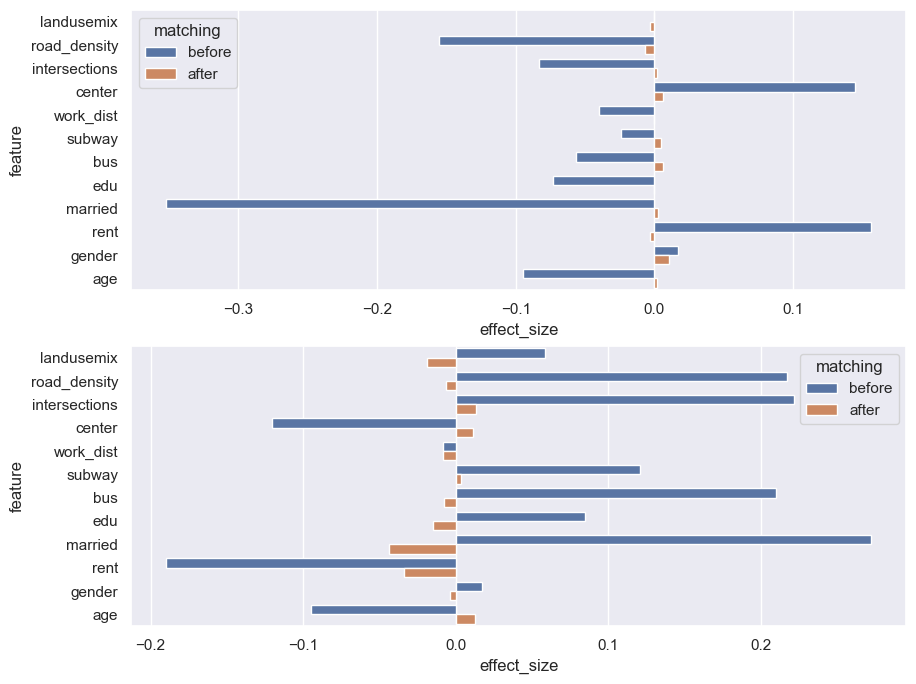

In [31]:
# 绘图
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
sns.barplot(data=effect_sizes_before, x='effect_size', y='feature', hue='matching', orient='h', ax=axs[0])
sns.barplot(data=effect_sizes_after, x='effect_size', y='feature', hue='matching', orient='h', ax=axs[1])

In [32]:
# 生成控制组和对照组出行数据
treatment_data1 = data[data['who'].isin(treatment_matched1['who'].unique())]
control_data1 = data[data['who'].isin(control_matched1['who'].unique())]

treatment_data2 = data[data['who'].isin(treatment_matched2['who'].unique())]
control_data2 = data[data['who'].isin(control_matched2['who'].unique())]

print(treatment_data1['who'].nunique(), control_data1['who'].nunique())

7974 7974


caliper (radius) is: 0.049
total observations in treatment: 21289
total matched observations in treatment: 6860
total matched observations in control: 6860


Text(0.5, 1.0, 'covariates difference')

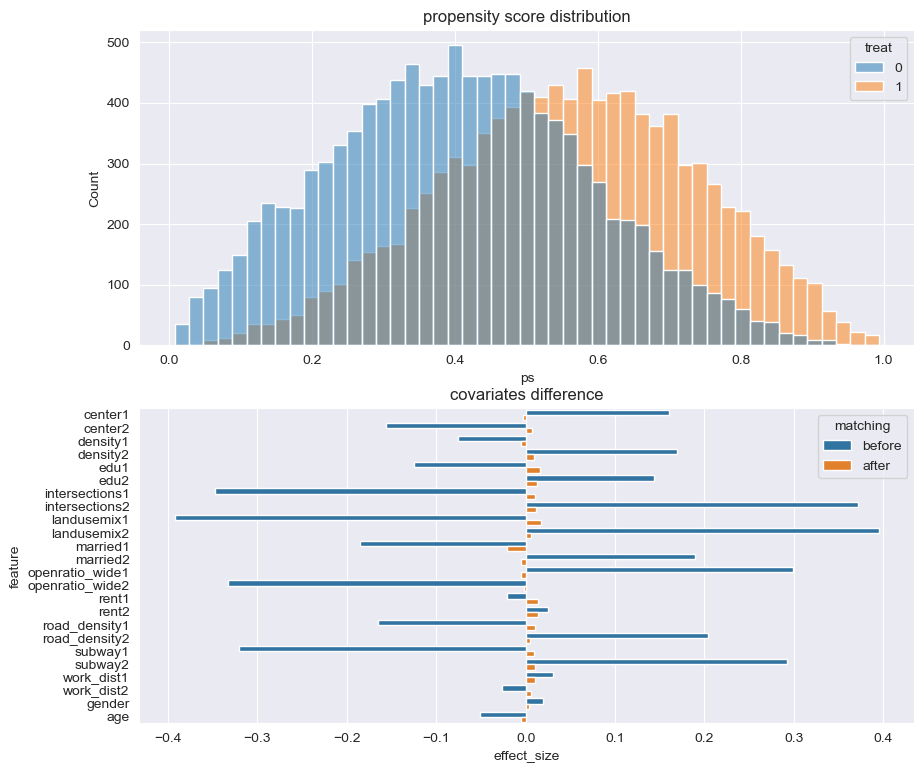

In [39]:
# ############################################################################################
# 补充代码，同时使用前后协变量才用
# 计算倾向得分
drop_cols = ['who','treat','bus1','bus2']
covariate_list = covariates_merge.drop(drop_cols, axis=1).columns.tolist() 
pred_prob = compute_propensity_score(covariates_merge[covariate_list], covariates_merge['treat'])
covariates_merge['ps'] = pred_prob[:,1]

# 倾向得分的logit形式
covariates_merge['logit_ps'] = covariates_merge['ps'].apply(logit)

# 匹配
covariates_merge = ps_matching(covariates_merge, 0.25, 20) # data, caliper_ratio, n_neighbors
# 删除没有匹配的数据
treatment_matched = covariates_merge.dropna(subset=['match'])  # 处置组
# 对照组
control_matched_idx = treatment_matched.match
control_matched_idx = control_matched_idx.astype(int)
control_matched = covariates_merge.loc[control_matched_idx,:]
# 检查匹配结果
print('total observations in treatment:', len(covariates_merge))
print('total matched observations in treatment:', len(treatment_matched))
print('total matched observations in control:', len(control_matched))

# 效应量计算
effect_sizes = compute_effect_size(
    covariates_merge[covariates_merge['treat']==1],
    treatment_matched,
    covariates_merge[covariates_merge['treat']==0],
    control_matched,
    covariate_list
)

# 生成控制组和对照组出行数据
treatment_data = data[data['who'].isin(treatment_matched['who'].unique())]
control_data = data[data['who'].isin(control_matched['who'].unique())]

# 绘图
fig, ax = plt.subplots(2,1,figsize=(10, 9))
sns.histplot(covariates_merge, x='ps', hue='treat', ax=ax[0])
ax[0].set_title('propensity score distribution')
sns.barplot(data=effect_sizes, x='effect_size', y='feature', hue='matching', orient='h', ax=ax[1])
ax[1].set_title('covariates difference')
# ############################################################################################

Text(0.5, 0, 'Propensity Score')

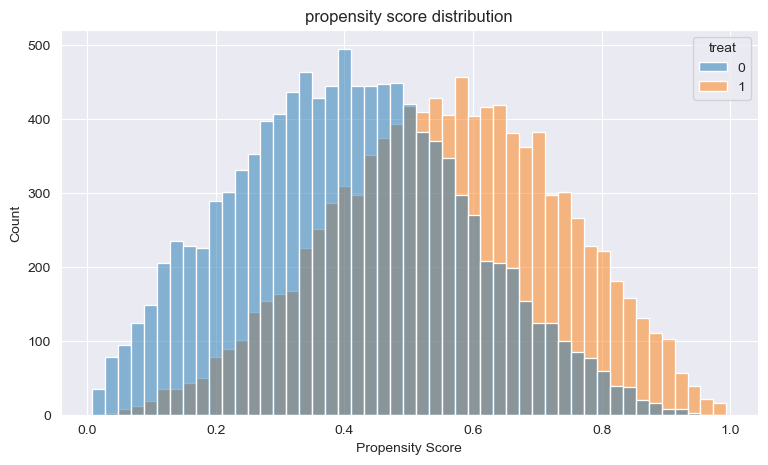

In [40]:
fig, ax = plt.subplots(figsize=(9, 5))
sns.histplot(covariates_merge, x='ps', hue='treat', ax=ax)
ax.set_title('propensity score distribution')
ax.set_xlabel('Propensity Score')
# sns.barplot(data=effect_sizes, x='effect_size', y='feature', hue='matching', orient='h', ax=ax[1])
# ax[1].set_title('covariates difference')

## step4: CITS回归
1. 使用iptw加权的回归，仅在搬家后控制其他建成环境变量
2. 在搬家前后都控制协变量

In [14]:
def generate_regress_data(treatment_data, control_data, covariates, change_data, weather, std_list=None, centralize=None):
    # 数据整合与变量标准化
    regress_data = pd.concat([treatment_data,control_data], axis=0).reset_index(drop=True)
    
    # 合并协变量
    covariates['move'] = covariates['group_id'] - 1
    regress_data = pd.merge(regress_data, covariates[['who','move']+features_list], on=['who','move'], how='left')
    # 将干预表达为变化量的形式
    
    regress_data = pd.merge(regress_data, change_data, on='who', how='left')
    
    # 添加天气变量（气温与降水）
    regress_data = pd.merge(regress_data, weather, on='date', how='left')
    
    # 添加ps得分（转化为权重形式）,weight = treat/ps + (1-treat)/1-ps
    # iptw_data = pd.concat([treatment_matched, control_matched1], axis=0).reset_index(drop=True)
    # iptw_data = iptw_data[['who','treat','ps','match']]
    # iptw_data['weight'] = iptw_data.apply(lambda row: row['treat']/row['ps'] + (1-row['treat'])/(1-row['ps']), axis=1)
    # regress_data = pd.merge(regress_data, iptw_data[['who','weight']], on='who', how='left')
    # 协变量处理，对于使用iptw加权的做法，搬家前的协变量可以为空
    # for feature in covariate_list:
    #     regress_data.loc[regress_data['T'] < regress_data['move_time'], feature] = np.nan
    
    # 变量标准化，只有当std_list不为空时才进行标准化
    if std_list is not None:
        scaler = StandardScaler()
        std_regress_data = regress_data[std_list]
        std_regress_data = scaler.fit_transform(std_regress_data)
        # 更新regress data
        regress_data[std_list] = std_regress_data
    
    # 变量中心化，当centralized被指定为处置变量时进行
    if centralize is not None:
        regress_data[centralize] = regress_data[centralize] - regress_data[centralize].mean()
    
    return regress_data

### subway

In [16]:
change_data = relative_changes_df[['who','subway']]
change_data.rename(columns={'subway':'subway_change'}, inplace=True)
weather = pd.read_csv('D:/317research/317研究组/4 居住自选择/data/weather_info.csv')

# std_list = ['metro_dist_ratio', 'walk_dist', 'chain_complexity', 'age', 'road_density', 'intersections', 'center', 'work_dist', 'subway', 'bus', 'edu', 'married', 'rent','density_change', 'temperature', 'percipit']
# 做中心化
centralize = ['metro_dist_ratio', 'walk_dist', 'chain_complexity', 'age', 'density', 'road_density', 'intersections', 'center', 'work_dist', 'bus', 'edu', 'married', 'rent','subway_change', 'temperature', 'percipit']
regress_data = generate_regress_data(treatment_data, control_data, covariates, change_data, weather, centralize=centralize)

C:\Users\317gy\AppData\Local\Temp\ipykernel_23268\3378601902.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_data.rename(columns={'subway':'subway_change'}, inplace=True)


In [50]:
# del regress_data
# gc.collect()

1970

In [22]:
regress_data.head()

,date,who,sum_dist,metro_dist,metro_dist_ratio,walk_dist,walk_dist_ratio,chain_complexity,gender,age,...,center,work_dist,subway,bus,edu,married,rent,subway_change,temperature,percipit
0,20190101,6717,21540.0,0.0,0.0,0.0,0.000000,2.0,0,3,...,6.177506,13.84748,0.355556,7.466667,0.248269,0.513453,3.361441,-0.410523,11.3,0.0
1,20190102,6717,32521.0,0.0,0.0,0.0,0.000000,4.0,0,3,...,6.177506,13.84748,0.355556,7.466667,0.248269,0.513453,3.361441,-0.410523,12.4,0.1
2,20190103,6717,48364.0,0.0,0.0,0.0,0.000000,6.0,0,3,...,6.177506,13.84748,0.355556,7.466667,0.248269,0.513453,3.361441,-0.410523,13.2,0.0
3,20190104,6717,20322.0,0.0,0.0,2263.0,0.111357,2.0,0,3,...,6.177506,13.84748,0.355556,7.466667,0.248269,0.513453,3.361441,-0.410523,17.2,0.1
4,20190105,6717,39216.0,0.0,0.0,0.0,0.000000,2.0,0,3,...,6.177506,13.84748,0.355556,7.466667,0.248269,0.513453,3.361441,-0.410523,18.6,0.0


In [43]:
# 定义回归模型
# formulas = 'metro_dist_ratio ~ treat + T + treat:T + subway_change:move + treat:subway_change:move + subway_change:P + treat:subway_change:P + gender + age + holiday + density + landusemix + road_density + intersections + center + work_dist + bus + edu + married + rent + temperature + percipit'
formulas = 'metro_dist_ratio ~ treat + T + treat:T + subway_change:move + treat:subway_change:move + subway_change:P + treat:subway_change:P + holiday + temperature + percipit'
# # 要加权计算，只能使用wls，而不能使用mixedlm
# wls_model = smf.wls(formulas, regress_data, weights=regress_data['weight'])
# # model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'], re_formula='1 + T', weights=regress_data['weight'])
# # 拟合模型
# result = wls_model.fit()
# # 查看回归结果
# print(result.summary())

In [38]:
# 随机效应模型 - before move，标准化变量
formulas = 'metro_dist_ratio ~ treat + T + treat:T + subway_change:move + treat:subway_change:move + subway_change:P + treat:subway_change:P + gender + age + holiday + density + landusemix + road_density + intersections + center + work_dist + bus + edu + married + rent + temperature + percipit'
mix_model1 = smf.mixedlm(formulas, regress_data, groups=regress_data['who'])
# 拟合模型
result = mix_model.fit()
# 查看回归结果
print(result.summary())

C:\Users\317gy\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   metro_dist_ratio
No. Observations:    4465410   Method:               REML            
No. Groups:          12234     Scale:                0.6610          
Min. group size:     365       Log-Likelihood:       -5460463.5877   
Max. group size:     365       Converged:            Yes             
Mean group size:     365.0                                           
---------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                -0.147    0.006  -23.266 0.000 -0.159 -0.134
treat                     0.078    0.008    9.607 0.000  0.062  0.094
T                         0.000    0.000   13.501 0.000  0.000  0.001
treat:T                   0.001    0.000   12.883 0.000  0.001  0.001
subway_change:move       -0.787    0

In [39]:
# 随机效应模型 - after move
mix_model2 = smf.mixedlm(formulas, regress_data2, groups=regress_data2['who'], re_formula='1 + T')
# 拟合模型
result2 = mix_model2.fit()
# 查看回归结果
print(result2.summary())

C:\Users\317gy\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   metro_dist_ratio
No. Observations:    4628930   Method:               REML            
No. Groups:          12682     Scale:                0.6628          
Min. group size:     365       Log-Likelihood:       -5666934.4091   
Max. group size:     365       Converged:            Yes             
Mean group size:     365.0                                           
---------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                -0.141    0.006  -22.717 0.000 -0.153 -0.129
treat                     0.095    0.008   11.820 0.000  0.079  0.111
T                         0.000    0.000   12.443 0.000  0.000  0.000
treat:T                   0.001    0.000   11.119 0.000  0.000  0.001
subway_change:move        0.236    0

In [44]:
# 随机效应模型 - 搬家前后数据同时匹配
mix_model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'], re_formula='1 + T')
# 拟合模型
result = mix_model.fit()
# 查看回归结果
print(result.summary())

C:\Users\317gy\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\317gy\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\317gy\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\317gy\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\317gy\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

                Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   metro_dist_ratio
No. Observations:    3960250   Method:               REML            
No. Groups:          10850     Scale:                0.6639          
Min. group size:     365       Log-Likelihood:       -4902836.8802   
Max. group size:     365       Converged:            No              
Mean group size:     365.0                                           
---------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                -0.113    0.006  -18.982 0.000 -0.125 -0.101
treat                     0.055    0.008    6.728 0.000  0.039  0.072
T                         0.000    0.003    0.145 0.885 -0.006  0.007
treat:T                   0.000    0.005    0.096 0.923 -0.009  0.010
subway_change:move        0.772    0

In [23]:
# 随机效应模型 - before move，中心化处置
formulas = 'metro_dist_ratio ~ treat + T + treat:T + move + subway_change:move + treat:move + treat:subway_change:move + P + subway_change:P + treat:P +treat:subway_change:P + gender + age + holiday + density + landusemix + road_density + intersections + center + work_dist + bus + edu + married + rent + temperature + percipit'
mix_model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'], re_formula='1 + T')
# 拟合模型
result = mix_model.fit()
# 查看回归结果
print(result.summary())

C:\Users\317gy\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\317gy\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\317gy\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\317gy\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\317gy\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

                    Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      metro_dist_ratio
No. Observations:      4465410      Method:                  REML            
No. Groups:            12234        Scale:                   0.0566          
Min. group size:       365          Log-Likelihood:          25274.8329      
Max. group size:       365          Converged:               No              
Mean group size:       365.0                                                 
-----------------------------------------------------------------------------
                         Coef.   Std.Err.    z     P>|z|   [0.025     0.975] 
-----------------------------------------------------------------------------
Intercept                 0.115     0.005   22.414 0.000      0.105     0.125
treat                     0.030     0.002   12.574 0.000      0.025     0.035
T                         0.000     0.000   14.973 0.000      0.000     0.000
treat:

C:\Users\317gy\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2706: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


In [17]:
formulas = 'walk_dist ~ treat + T + treat:T + subway_change:move + treat:subway_change:move + subway_change:P + treat:subway_change:P + holiday + temperature + percipit'
# 随机效应模型 - 搬家前后数据同时匹配
mix_model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'])
# 拟合模型
result = mix_model.fit()
# 查看回归结果
print(result.summary())

                  Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     walk_dist     
No. Observations:       3960250     Method:                 REML          
No. Groups:             10850       Scale:                  321737.5215   
Min. group size:        365         Log-Likelihood:         -30747774.1052
Max. group size:        365         Converged:              Yes           
Mean group size:        365.0                                             
--------------------------------------------------------------------------
                           Coef.   Std.Err.    z    P>|z|  [0.025   0.975]
--------------------------------------------------------------------------
Intercept                  -26.745    2.341 -11.423 0.000  -31.334 -22.156
treat                        5.862    3.138   1.868 0.062   -0.289  12.013
T                            0.190    0.012  16.406 0.000    0.167   0.213
treat:T                     -0.049    0.012 

### density

In [15]:
change_data = relative_changes_df[['who','density']]
change_data.rename(columns={'density':'density_change'}, inplace=True)
weather = pd.read_csv('D:/317research/317研究组/4 居住自选择/data/weather_info.csv')

# std_list = ['metro_dist_ratio', 'walk_dist', 'chain_complexity', 'age', 'road_density', 'intersections', 'center', 'work_dist', 'subway', 'bus', 'edu', 'married', 'rent','density_change', 'temperature', 'percipit']
# 做中心化
centralize = ['metro_dist_ratio', 'walk_dist', 'chain_complexity', 'age', 'road_density', 'intersections', 'center', 'work_dist', 'subway', 'bus', 'edu', 'married', 'rent','density_change', 'temperature', 'percipit']
regress_data = generate_regress_data(treatment_data, control_data, covariates, change_data, weather, centralize=centralize)

C:\Users\317gy\AppData\Local\Temp\ipykernel_51272\2301410385.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_data.rename(columns={'density':'density_change'}, inplace=True)


In [18]:
regress_data.head()

,date,who,sum_dist,metro_dist,metro_dist_ratio,walk_dist,walk_dist_ratio,chain_complexity,gender,age,...,center,work_dist,subway,bus,edu,married,rent,density_change,temperature,percipit
0,20190101,9856,0.0,NaN,-0.127635,-119.446966,NaN,-1.501547,0,0.580432,...,-0.494665,1.148992,-0.479424,-0.735827,0.284402,0.149108,1.203907,3.811064,-12.731507,-5.16411
1,20190102,9856,0.0,NaN,-0.127635,-119.446966,NaN,-1.501547,0,0.580432,...,-0.494665,1.148992,-0.479424,-0.735827,0.284402,0.149108,1.203907,3.811064,-11.631507,-5.06411
2,20190103,9856,0.0,NaN,-0.127635,-119.446966,NaN,-1.501547,0,0.580432,...,-0.494665,1.148992,-0.479424,-0.735827,0.284402,0.149108,1.203907,3.811064,-10.831507,-5.16411
3,20190104,9856,0.0,NaN,-0.127635,-119.446966,NaN,-1.501547,0,0.580432,...,-0.494665,1.148992,-0.479424,-0.735827,0.284402,0.149108,1.203907,3.811064,-6.831507,-5.06411
4,20190105,9856,0.0,NaN,-0.127635,-119.446966,NaN,-1.501547,0,0.580432,...,-0.494665,1.148992,-0.479424,-0.735827,0.284402,0.149108,1.203907,3.811064,-5.431507,-5.16411


#### walk dist fit

In [19]:
# 定义回归公式
formulas = 'walk_dist ~ treat + T + treat:T + density_change:move + treat:density_change:move + density_change:P + treat:density_change:P + gender + age + holiday + subway + landusemix + road_density + intersections + center + work_dist + bus + edu + married + rent + temperature + percipit'

In [39]:
# 随机效应模型 - before move，包括所有协变量，只匹配搬家前变量，正负对照
mix_model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'])
# 拟合模型
result = mix_model.fit()
# 查看回归结果
print(result.summary())

                  Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     walk_dist     
No. Observations:       5821020     Method:                 REML          
No. Groups:             15948       Scale:                  312988.3356   
Min. group size:        365         Log-Likelihood:         -45114509.7921
Max. group size:        365         Converged:              Yes           
Mean group size:        365.0                                             
--------------------------------------------------------------------------
                            Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------
Intercept                    -3.476    3.712  -0.937 0.349 -10.752   3.799
treat                         4.856    2.454   1.979 0.048   0.045   9.666
T                             0.128    0.005  27.674 0.000   0.119   0.137
treat:T                      -0.022    0.006

In [21]:
# 随机效应模型 - 用前后的协变量匹配，如果协变量不控制？
formulas_pure = 'walk_dist ~ treat + T + treat:T + density_change:move + treat:density_change:move + density_change:P + treat:density_change:P + holiday + temperature + percipit'
mix_model = smf.mixedlm(formulas_pure, regress_data, groups=regress_data['who'])
# 拟合模型
result = mix_model.fit()
# 查看回归结果
print(result.summary())

                  Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     walk_dist     
No. Observations:       5409300     Method:                 REML          
No. Groups:             14820       Scale:                  313661.4115   
Min. group size:        365         Log-Likelihood:         -41929598.3378
Max. group size:        365         Converged:              Yes           
Mean group size:        365.0                                             
--------------------------------------------------------------------------
                            Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   -19.135    1.846 -10.367 0.000 -22.752 -15.517
treat                         4.165    2.581   1.614 0.107  -0.893   9.223
T                             0.130    0.005  27.145 0.000   0.121   0.139
treat:T                      -0.036    0.007

In [20]:
formulas = 'walk_dist ~ treat + T + treat:T + move + treat:move + density_change:move + treat:density_change:move + P + treat:P + density_change:P + treat:density_change:P + holiday + temperature + percipit'
mix_model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'])
# 拟合模型
result = mix_model.fit()
# 查看回归结果
print(result.summary())

                  Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     walk_dist     
No. Observations:       5409300     Method:                 REML          
No. Groups:             14820       Scale:                  313650.5347   
Min. group size:        365         Log-Likelihood:         -41929510.4578
Max. group size:        365         Converged:              Yes           
Mean group size:        365.0                                             
--------------------------------------------------------------------------
                            Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   -27.865    2.021 -13.788 0.000 -31.826 -23.904
treat                         3.337    2.706   1.233 0.218  -1.968   8.641
T                             0.219    0.010  20.899 0.000   0.198   0.239
treat:T                      -0.029    0.013

In [16]:
# 对变化量取绝对值 - 并没有本质区别，只是符号不同
regress_data['density_change'] = regress_data['density_change'].apply(lambda x: abs(x))
formulas = 'walk_dist ~ treat + T + treat:T + move + treat:move + density_change:move + treat:density_change:move + P + treat:P + density_change:P + treat:density_change:P + holiday + temperature + percipit'
mix_model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'])
# 拟合模型
result = mix_model.fit()
# 查看回归结果
print(result.summary())

                  Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     walk_dist     
No. Observations:       5409300     Method:                 REML          
No. Groups:             14820       Scale:                  313650.5367   
Min. group size:        365         Log-Likelihood:         -41929510.4693
Max. group size:        365         Converged:              Yes           
Mean group size:        365.0                                             
--------------------------------------------------------------------------
                            Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   -27.865    2.021 -13.788 0.000 -31.826 -23.904
treat                         3.337    2.706   1.233 0.218  -1.968   8.641
T                             0.219    0.010  20.899 0.000   0.198   0.239
treat:T                      -0.029    0.013

#### trip chain complexity fit

In [16]:
formulas_pure = 'chain_complexity ~ treat + T + treat:T + density_change:move + treat:density_change:move + density_change:P + treat:density_change:P + holiday + temperature + percipit'
mix_model = smf.mixedlm(formulas_pure, regress_data, groups=regress_data['who'])
# 拟合模型
result = mix_model.fit()
# 查看回归结果
print(result.summary())

                Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   chain_complexity
No. Observations:     5409300   Method:               REML            
No. Groups:           14820     Scale:                1.8721          
Min. group size:      365       Log-Likelihood:       -9407151.1764   
Max. group size:      365       Converged:            Yes             
Mean group size:      365.0                                           
----------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                 -0.030    0.009   -3.216 0.001 -0.049 -0.012
treat                     -0.015    0.013   -1.122 0.262 -0.041  0.011
T                          0.001    0.000   71.048 0.000  0.001  0.001
treat:T                   -0.000    0.000   -4.040 0.000 -0.000 -0.000
density_change:move    

#### Robustness check: 二次方时间趋势

In [38]:
regress_data.head()

,date,who,sum_dist,metro_dist,metro_dist_ratio,walk_dist,walk_dist_ratio,chain_complexity,gender,age,...,work_dist,subway,bus,edu,married,rent,density_change,temperature,percipit,first_week
0,20190101,9856,0.0,NaN,-0.127635,-119.446966,NaN,-1.501547,0,0.580432,...,1.148992,-0.479424,-0.735827,0.284402,0.149108,1.203907,3.811064,-12.731507,-5.16411,1
1,20190102,9856,0.0,NaN,-0.127635,-119.446966,NaN,-1.501547,0,0.580432,...,1.148992,-0.479424,-0.735827,0.284402,0.149108,1.203907,3.811064,-11.631507,-5.06411,1
2,20190103,9856,0.0,NaN,-0.127635,-119.446966,NaN,-1.501547,0,0.580432,...,1.148992,-0.479424,-0.735827,0.284402,0.149108,1.203907,3.811064,-10.831507,-5.16411,1
3,20190104,9856,0.0,NaN,-0.127635,-119.446966,NaN,-1.501547,0,0.580432,...,1.148992,-0.479424,-0.735827,0.284402,0.149108,1.203907,3.811064,-6.831507,-5.06411,1
4,20190105,9856,0.0,NaN,-0.127635,-119.446966,NaN,-1.501547,0,0.580432,...,1.148992,-0.479424,-0.735827,0.284402,0.149108,1.203907,3.811064,-5.431507,-5.16411,1


In [37]:
# 在数据中添加时间的二次方
regress_data['P2'] = regress_data['P']**2

KeyboardInterrupt: 

In [ ]:
formulas = 'walk_dist ~ treat + T + treat:T + first_week + treat:first_week + density_change:move + treat:density_change:move + density_change:P + density_change:P2 + treat:density_change:P + treat:density_change:P2 + holiday + temperature + percipit'
mix_model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'])
# 拟合模型
result = mix_model.fit()
# 查看回归结果
print(result.summary())

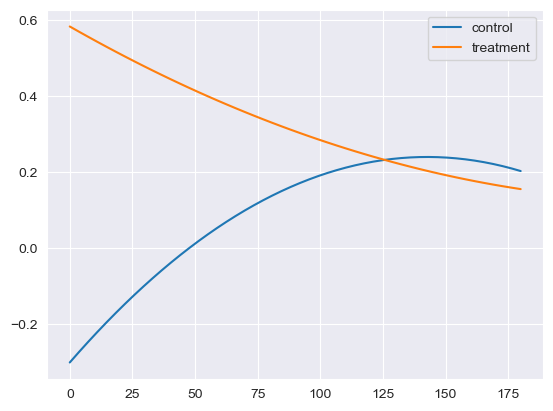

In [40]:
x = np.linspace(0, 180)
y1 = result.fe_params['density_change:move'] + (result.fe_params['density_change:P'])*x + result.fe_params['density_change:P2']*x**2
plt.plot(x, y1, label='control')
y2 = result.fe_params['treat:density_change:move'] + (result.fe_params['density_change:P'] + result.fe_params['treat:density_change:P'])*x + (result.fe_params['density_change:P2'] + result.fe_params['treat:density_change:P2'])*x**2
plt.plot(x, y2, label='treatment')
plt.legend()

#### Robustness checks: 删除搬家前后两周

In [16]:
# 删除搬家前后两周
regress_data = regress_data[(regress_data['T']>regress_data['move_time']+7) | (regress_data['T']<=regress_data['move_time']-7)]
regress_data.reset_index(drop=True, inplace=True)

# 重构T
n_days = 365 - 14
sample = len(regress_data['who'].unique())
T = np.tile(np.arange(1,n_days+1),sample)
regress_data['T'] = T

# 重构P
regress_data['P'] = regress_data['P'] - 7
regress_data['P'] = regress_data['P'].apply(lambda x: np.clip(x, 0, None))

In [17]:
regress_data['T'].max()

351

In [18]:
# 随机效应模型 - 用前后的协变量匹配，如果协变量不控制？
formulas_pure = 'walk_dist ~ treat + T + treat:T + density_change:move + treat:density_change:move + density_change:P + treat:density_change:P + holiday + temperature + percipit'
mix_model = smf.mixedlm(formulas_pure, regress_data, groups=regress_data['who'])
# 拟合模型
result = mix_model.fit()
# 查看回归结果
print(result.summary())

                  Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     walk_dist     
No. Observations:       5201820     Method:                 REML          
No. Groups:             14820       Scale:                  312732.7566   
Min. group size:        351         Log-Likelihood:         -40314386.8300
Max. group size:        351         Converged:              Yes           
Mean group size:        351.0                                             
--------------------------------------------------------------------------
                            Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   -19.894    1.864 -10.674 0.000 -23.547 -16.241
treat                         4.360    2.603   1.675 0.094  -0.742   9.463
T                             0.136    0.005  26.845 0.000   0.126   0.146
treat:T                      -0.035    0.007

### landusemix

In [15]:
change_data = relative_changes_df[['who','landusemix']]
change_data.rename(columns={'landusemix':'landusemix_change'}, inplace=True)
weather = pd.read_csv('D:/317research/317研究组/4 居住自选择/data/weather_info.csv')
centralize = ['metro_dist_ratio', 'walk_dist', 'chain_complexity', 'age', 'density', 'road_density', 'intersections', 'center', 'work_dist', 'subway', 'bus', 'edu', 'married', 'rent','landusemix_change', 'temperature', 'percipit']
regress_data = generate_regress_data(treatment_data, control_data, covariates, change_data, weather, centralize=centralize)

C:\Users\317gy\AppData\Local\Temp\ipykernel_35304\2602871665.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_data.rename(columns={'landusemix':'landusemix_change'}, inplace=True)


In [33]:
regress_data.to_csv('D:/317research/317研究组/4 居住自选择/data/regress_data/landusemix_positive_negative_comparison.csv', index=False)

In [24]:
# 定义回归公式
formulas = 'walk_dist ~ treat + T + treat:T + landusemix_change:move + treat:landusemix_change:move + landusemix_change:P + treat:landusemix_change:P + gender + age + holiday + subway + density + road_density + intersections + center + work_dist + bus + edu + married + rent + temperature + percipit'
# 随机效应模型 - before move，包括所有协变量，只匹配搬家前变量，正负对照
mix_model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'])
# 拟合模型
result = mix_model.fit()
# 查看回归结果
print(result.summary())

                 Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     walk_dist    
No. Observations:      5577930     Method:                 REML         
No. Groups:            15282       Scale:                  0.9399       
Min. group size:       365         Log-Likelihood:         -7766184.8341
Max. group size:       365         Converged:              Yes          
Mean group size:       365.0                                            
------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                    -0.011    0.003  -3.345 0.001 -0.018 -0.005
treat                        -0.002    0.004  -0.442 0.658 -0.010  0.007
T                             0.000    0.000  24.040 0.000  0.000  0.000
treat:T                      -0.000    0.000  -2.180 0.029 -0.000 -0.

In [17]:
formulas = 'walk_dist ~ treat + T + treat:T + landusemix_change:move + treat:landusemix_change:move + landusemix_change:P + treat:landusemix_change:P + holiday + temperature + percipit'
# 随机效应模型 - 搬家前后数据同时匹配
mix_model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'])
# 拟合模型
result = mix_model.fit()
# 查看回归结果
print(result.summary())

                    Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      walk_dist     
No. Observations:        5074230      Method:                  REML          
No. Groups:              13902        Scale:                   314528.4087   
Min. group size:         365          Log-Likelihood:          -39338719.6828
Max. group size:         365          Converged:               Yes           
Mean group size:         365.0                                               
-----------------------------------------------------------------------------
                               Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------------
Intercept                      -13.761    1.836  -7.496 0.000 -17.359 -10.163
treat                           -4.082    2.567  -1.590 0.112  -9.114   0.950
T                                0.109    0.005  22.765 0.000   0.100   0.118
treat:

In [16]:
formulas = 'walk_dist ~ treat + T + treat:T + move + treat:move + landusemix_change:move + treat:landusemix_change:move + P + treat:P + landusemix_change:P + treat:landusemix_change:P + holiday + temperature + percipit'
# 随机效应模型 - 搬家前后数据同时匹配
mix_model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'])
# 拟合模型
result = mix_model.fit()
# 查看回归结果
print(result.summary())

                    Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      walk_dist     
No. Observations:        5074230      Method:                  REML          
No. Groups:              13902        Scale:                   314509.6173   
Min. group size:         365          Log-Likelihood:          -39338575.9015
Max. group size:         365          Converged:               Yes           
Mean group size:         365.0                                               
-----------------------------------------------------------------------------
                               Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------------
Intercept                      -24.417    2.028 -12.042 0.000 -28.391 -20.443
treat                           -6.136    2.705  -2.269 0.023 -11.437  -0.835
T                                0.210    0.011  19.310 0.000   0.189   0.231
treat:

### road density

In [19]:
change_data = relative_changes_df[['who','road_density']]
change_data.rename(columns={'road_density':'road_density_change'}, inplace=True)
weather = pd.read_csv('D:/317research/317研究组/4 居住自选择/data/weather_info.csv')
centralize = ['metro_dist_ratio', 'walk_dist', 'chain_complexity', 'age', 'density', 'landusemix', 'intersections', 'center', 'work_dist', 'subway', 'bus', 'edu', 'married', 'rent','road_density_change', 'temperature', 'percipit']
regress_data = generate_regress_data(treatment_data, control_data, covariates, change_data, weather, centralize=centralize)

C:\Users\317gy\AppData\Local\Temp\ipykernel_35120\1989317549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_data.rename(columns={'road_density':'road_density_change'}, inplace=True)


In [19]:
formulas = 'walk_dist ~ treat + T + treat:T + road_density_change:move + treat:road_density_change:move + road_density_change:P + treat:road_density_change:P + holiday + temperature + percipit'
# 随机效应模型 - 搬家前后数据同时匹配
mix_model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'])
# 拟合模型
result = mix_model.fit()
# 查看回归结果
print(result.summary())

                     Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       walk_dist     
No. Observations:        3604010       Method:                   REML          
No. Groups:              9874          Scale:                    315781.1234   
Min. group size:         365           Log-Likelihood:           -27948214.6953
Max. group size:         365           Converged:                Yes           
Mean group size:         365.0                                                 
-------------------------------------------------------------------------------
                                 Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------------------
Intercept                        -18.375    2.261  -8.126 0.000 -22.807 -13.943
treat                              0.846    3.161   0.267 0.789  -5.350   7.042
T                                  0.122    0.006  21.529 0.0

In [20]:
formulas = 'walk_dist ~ treat + T + treat:T + move + treat:move + road_density_change:move + treat:road_density_change:move + P + treat:P + road_density_change:P + treat:road_density_change:P + holiday + temperature + percipit'
# 随机效应模型 - 搬家前后数据同时匹配
mix_model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'])
# 拟合模型
result = mix_model.fit()
# 查看回归结果
print(result.summary())

                     Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       walk_dist     
No. Observations:        3604010       Method:                   REML          
No. Groups:              9874          Scale:                    315757.0583   
Min. group size:         365           Log-Likelihood:           -27948081.7058
Max. group size:         365           Converged:                Yes           
Mean group size:         365.0                                                 
-------------------------------------------------------------------------------
                                 Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------------------
Intercept                        -28.107    2.484 -11.315 0.000 -32.975 -23.238
treat                             -3.849    3.323  -1.158 0.247 -10.363   2.664
T                                  0.203    0.013  15.697 0.0

### Openratio_wide

In [17]:
change_data = relative_changes_df[['who','openratio_wide']]
change_data.rename(columns={'openratio_wide':'openratio_wide_change'}, inplace=True)
weather = pd.read_csv('D:/317research/317研究组/4 居住自选择/data/weather_info.csv')
centralize = ['metro_dist_ratio', 'walk_dist', 'chain_complexity', 'age', 'density', 'landusemix','road_density', 'intersections', 'center', 'work_dist', 'subway', 'bus', 'edu', 'married', 'rent','openratio_wide_change', 'temperature', 'percipit']
regress_data = generate_regress_data(treatment_data, control_data, covariates, change_data, weather, centralize=centralize)

C:\Users\317gy\AppData\Local\Temp\ipykernel_56484\2565407985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_data.rename(columns={'openratio_wide':'openratio_wide_change'}, inplace=True)


In [18]:
formulas = 'walk_dist ~ treat + T + treat:T + move + treat:move + openratio_wide_change:move + treat:openratio_wide_change:move + P + treat:P + openratio_wide_change:P + treat:openratio_wide_change:P + holiday + temperature + percipit'
# 随机效应模型 - 搬家前后数据同时匹配
mix_model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'])
# 拟合模型
result = mix_model.fit()
# 查看回归结果
print(result.summary())

                      Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        walk_dist     
No. Observations:        4919470        Method:                    REML          
No. Groups:              13478          Scale:                     316159.7558   
Min. group size:         365            Log-Likelihood:            -38152066.5415
Max. group size:         365            Converged:                 Yes           
Mean group size:         365.0                                                   
---------------------------------------------------------------------------------
                                   Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------------------
Intercept                          -26.471    2.108 -12.557 0.000 -30.603 -22.340
treat                               -3.082    2.821  -1.093 0.275  -8.610   2.446
T                                    0

### intersections

In [15]:
change_data = relative_changes_df[['who','intersections']]
change_data.rename(columns={'intersections':'intersections_change'}, inplace=True)
weather = pd.read_csv('D:/317research/317研究组/4 居住自选择/data/weather_info.csv')
centralize = ['metro_dist_ratio', 'walk_dist', 'chain_complexity', 'age', 'density', 'landusemix', 'road_density', 'center', 'work_dist', 'subway', 'bus', 'edu', 'married', 'rent','intersections_change', 'temperature', 'percipit']
regress_data = generate_regress_data(treatment_data, control_data, covariates, change_data, weather, centralize=centralize)

C:\Users\317gy\AppData\Local\Temp\ipykernel_34140\3390747964.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_data.rename(columns={'intersections':'intersections_change'}, inplace=True)


In [19]:
formulas = 'walk_dist ~ treat + T + treat:T + intersections_change:move + treat:intersections_change:move + intersections_change:P + treat:intersections_change:P + holiday + temperature + percipit'
# 随机效应模型 - 搬家前后数据同时匹配
mix_model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'])
# 拟合模型
result = mix_model.fit()
# 查看回归结果
print(result.summary())

                     Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       walk_dist     
No. Observations:         3409830       Method:                   REML          
No. Groups:               9342          Scale:                    316861.6373   
Min. group size:          365           Log-Likelihood:           -26448227.0763
Max. group size:          365           Converged:                Yes           
Mean group size:          365.0                                                 
--------------------------------------------------------------------------------
                                  Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------------
Intercept                         -15.687    2.324  -6.749 0.000 -20.243 -11.132
treat                              -4.080    3.254  -1.254 0.210 -10.457   2.298
T                                   0.110    0.006

In [16]:
formulas = 'walk_dist ~ treat + T + treat:T + move + treat:move + intersections_change:move + treat:intersections_change:move + P + treat:P + intersections_change:P + treat:intersections_change:P + holiday + temperature + percipit'
# 随机效应模型 - 搬家前后数据同时匹配
mix_model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'])
# 拟合模型
result = mix_model.fit()
# 查看回归结果
print(result.summary())

                     Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       walk_dist     
No. Observations:         3409830       Method:                   REML          
No. Groups:               9342          Scale:                    316843.8199   
Min. group size:          365           Log-Likelihood:           -26448135.2268
Max. group size:          365           Converged:                Yes           
Mean group size:          365.0                                                 
--------------------------------------------------------------------------------
                                  Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------------
Intercept                         -26.878    2.557 -10.513 0.000 -31.890 -21.867
treat                              -4.604    3.423  -1.345 0.179 -11.313   2.105
T                                   0.217    0.013

### center

In [15]:
change_data = relative_changes_df[['who','center']]
change_data.rename(columns={'center':'center_change'}, inplace=True)
weather = pd.read_csv('D:/317research/317研究组/4 居住自选择/data/weather_info.csv')
centralize = ['metro_dist_ratio', 'walk_dist', 'chain_complexity', 'age', 'density', 'landusemix', 'road_density', 'intersections', 'work_dist', 'subway', 'bus', 'edu', 'married', 'rent','center_change', 'temperature', 'percipit']
regress_data = generate_regress_data(treatment_data, control_data, covariates, change_data, weather, centralize=centralize)

C:\Users\317gy\AppData\Local\Temp\ipykernel_31664\3032604366.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_data.rename(columns={'center':'center_change'}, inplace=True)


In [17]:
formulas = 'walk_dist ~ treat + T + treat:T + center_change:move + treat:center_change:move + center_change:P + treat:center_change:P + holiday + temperature + percipit'
# 随机效应模型 - 搬家前后数据同时匹配
mix_model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'])
# 拟合模型
result = mix_model.fit()
# 查看回归结果
print(result.summary())

                  Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     walk_dist     
No. Observations:      5750940     Method:                 REML          
No. Groups:            15756       Scale:                  316781.7838   
Min. group size:       365         Log-Likelihood:         -44606052.9608
Max. group size:       365         Converged:              Yes           
Mean group size:       365.0                                             
-------------------------------------------------------------------------
                           Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------------
Intercept                  -18.959    1.787 -10.612 0.000 -22.461 -15.458
treat                        1.337    2.494   0.536 0.592  -3.551   6.224
T                            0.120    0.005  24.353 0.000   0.110   0.129
treat:T                      0.021    0.007   3.186 0.00

In [16]:
formulas = 'walk_dist ~ treat + T + treat:T + move + treat:move + center_change:move + treat:center_change:move + P + treat:P + center_change:P + treat:center_change:P + holiday + temperature + percipit'
# 随机效应模型 - 搬家前后数据同时匹配
mix_model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'])
# 拟合模型
result = mix_model.fit()
# 查看回归结果
print(result.summary())

                  Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     walk_dist     
No. Observations:      5750940     Method:                 REML          
No. Groups:            15756       Scale:                  316768.7323   
Min. group size:       365         Log-Likelihood:         -44605941.4903
Max. group size:       365         Converged:              Yes           
Mean group size:       365.0                                             
-------------------------------------------------------------------------
                           Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------------
Intercept                  -27.683    1.954 -14.170 0.000 -31.512 -23.854
treat                        2.023    2.613   0.774 0.439  -3.098   7.145
T                            0.205    0.010  20.125 0.000   0.185   0.225
treat:T                      0.008    0.012   0.624 0.53

#### Robustness check: 删除搬家前后两周

In [17]:
# 删除搬家前后两周
regress_data = regress_data[(regress_data['T']>regress_data['move_time']+7) | (regress_data['T']<=regress_data['move_time']-7)]
regress_data.reset_index(drop=True, inplace=True)

# 重构T
n_days = 365 - 14
sample = len(regress_data['who'].unique())
T = np.tile(np.arange(1,n_days+1),sample)
regress_data['T'] = T

# 重构P
regress_data['P'] = regress_data['P'] - 7
regress_data['P'] = regress_data['P'].apply(lambda x: np.clip(x, 0, None))

C:\Users\317gy\AppData\Local\Temp\ipykernel_31664\1198575507.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regress_data['T'] = T
C:\Users\317gy\AppData\Local\Temp\ipykernel_31664\1198575507.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regress_data['P'] = regress_data['P'] - 7
C:\Users\317gy\AppData\Local\Temp\ipykernel_31664\1198575507.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [18]:
formulas = 'walk_dist ~ treat + T + treat:T + move + treat:move + center_change:move + treat:center_change:move + P + treat:P + center_change:P + treat:center_change:P + holiday + temperature + percipit'
# 随机效应模型 - 搬家前后数据同时匹配
mix_model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'])
# 拟合模型
result = mix_model.fit()
# 查看回归结果
print(result.summary())

                  Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     walk_dist     
No. Observations:      5530356     Method:                 REML          
No. Groups:            15756       Scale:                  315515.4054   
Min. group size:       351         Log-Likelihood:         -42884866.5402
Max. group size:       351         Converged:              Yes           
Mean group size:       351.0                                             
-------------------------------------------------------------------------
                           Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------------
Intercept                  -26.227    1.970 -13.314 0.000 -30.088 -22.366
treat                        1.764    2.634   0.670 0.503  -3.399   6.927
T                            0.192    0.011  18.184 0.000   0.172   0.213
treat:T                      0.012    0.013   0.919 0.35

### bus

In [15]:
change_data = relative_changes_df[['who','bus']]
change_data.rename(columns={'bus':'bus_change'}, inplace=True)
weather = pd.read_csv('D:/317research/317研究组/4 居住自选择/data/weather_info.csv')
centralize = ['metro_dist_ratio', 'walk_dist', 'chain_complexity', 'age', 'density', 'landusemix', 'road_density', 'intersections', 'center', 'work_dist', 'subway', 'edu', 'married', 'rent','bus_change', 'temperature', 'percipit']
regress_data = generate_regress_data(treatment_data, control_data, covariates, change_data, weather, centralize=centralize)

C:\Users\317gy\AppData\Local\Temp\ipykernel_36856\2623368565.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_data.rename(columns={'bus':'bus_change'}, inplace=True)


In [17]:
formulas = 'walk_dist ~ treat + T + treat:T + bus_change:move + treat:bus_change:move + bus_change:P + treat:bus_change:P + holiday + temperature + percipit'
# 随机效应模型 - 搬家前后数据同时匹配
mix_model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'])
# 拟合模型
result = mix_model.fit()
# 查看回归结果
print(result.summary())

                Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    walk_dist     
No. Observations:     5007800    Method:                REML          
No. Groups:           13720      Scale:                 314187.9843   
Min. group size:      365        Log-Likelihood:        -38821179.2567
Max. group size:      365        Converged:             Yes           
Mean group size:      365.0                                           
----------------------------------------------------------------------
                        Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
----------------------------------------------------------------------
Intercept               -17.867    1.869  -9.562 0.000 -21.529 -14.204
treat                     2.098    2.612   0.803 0.422  -3.022   7.217
T                         0.108    0.005  21.843 0.000   0.098   0.117
treat:T                   0.007    0.007   1.068 0.286  -0.006   0.021
bus_change:move        

In [16]:
formulas = 'walk_dist ~ treat + T + treat:T + move + treat:move + bus_change:move + treat:bus_change:move + P + treat:P + bus_change:P + treat:bus_change:P + holiday + temperature + percipit'
# 随机效应模型 - 搬家前后数据同时匹配
mix_model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'])
# 拟合模型
result = mix_model.fit()
# 查看回归结果
print(result.summary())

                Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    walk_dist     
No. Observations:     5007800    Method:                REML          
No. Groups:           13720      Scale:                 314177.5198   
Min. group size:      365        Log-Likelihood:        -38821102.7968
Max. group size:      365        Converged:             Yes           
Mean group size:      365.0                                           
----------------------------------------------------------------------
                        Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
----------------------------------------------------------------------
Intercept               -26.438    2.056 -12.858 0.000 -30.469 -22.408
treat                     2.060    2.746   0.750 0.453  -3.322   7.442
T                         0.191    0.011  17.522 0.000   0.170   0.212
treat:T                   0.010    0.013   0.747 0.455  -0.016   0.035
move                   